In [1]:
%set_env TRANSFORMERS_CACHE=/bigstor/zsarwar/models/cache
%set_env CUDA_VISIBLE_DEVICES=0

env: TRANSFORMERS_CACHE=/bigstor/zsarwar/models/cache
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoTokenizer, AutoModelWithLMHead, AutoModelForMaskedLM
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch.nn.functional as F
import torch
from scipy.stats import entropy
import sys


/home/zsarwar/.conda/envs/nlp2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(precision=10)
torch.set_printoptions(threshold=sys.maxsize)

# Baseline / Template Phrase / Template phrase with gradient hotword


In [4]:
all_numpy = ["/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_0_end_idx_1000_filter_false.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_1000_end_idx_2000_filter_false.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_2000_end_idx_3000_filter_false.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_3000_end_idx_4000_filter_false.npy",
            "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_with_baseline_and_template_phrase_single_entity_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_1_start_idx_4000_end_idx_5000_filter_false.npy"]

In [5]:
trigger_type="template_hotword"
real_baseline = 'real_base'
template_baseline = 'template_base'
adversarial = 'adversarial'

In [6]:
# Store top-k probabilities and ranks for the successful examples

In [7]:
all_adversarial_top_k_probs = []
all_real_baseline_top_k_probs = []
all_template_baseline_top_k_probs = []
all_adversarial_trackers = []
all_real_baseline_trackers = []
all_template_baseline_trackers = []

all_true_labels = []
all_adv_labels = []
all_fail_indices = []

# Subsample adversarial instances and their first success indices as well as their original counterparts

for numpy_file in all_numpy:
    loaded_dict = np.load(numpy_file, allow_pickle=True)
    loaded_dict = loaded_dict.item()
    for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
        first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
        if (first_succ_rank != -100):
            true_label = loaded_dict['results_adversarial']['all_labels_triggers'][i][0]
            adv_label = loaded_dict['results_adversarial']['all_pred_labels_triggers'][i][first_succ_rank][0]
            adv_top_k = loaded_dict['results_adversarial']['adv_top_k'][i][first_succ_rank.item()]
            base_real_top_k = loaded_dict["results_baseline_real"]['base_real_top_k'][i]
            base_template_top_k = loaded_dict["results_baseline_template"]['base_template_top_k'][i]    
            
            real_tracker = loaded_dict["results_baseline_real"]['base_real_rank_prob_tracker'][i][first_succ_rank]
            template_tracker = loaded_dict["results_baseline_template"]['base_template_rank_prob_tracker'][i][first_succ_rank]
            adv_tracker = loaded_dict["results_adversarial"]['adv_rank_prob_tracker'][i][first_succ_rank]
            
            
            
            
            all_adversarial_top_k_probs.append(adv_top_k)
            all_real_baseline_top_k_probs.append(base_real_top_k)
            all_template_baseline_top_k_probs.append(base_template_top_k)

            all_real_baseline_trackers.append(real_tracker)
            all_template_baseline_trackers.append(template_tracker)
            all_adversarial_trackers.append(adv_tracker)
            all_true_labels.append(true_label)
            all_adv_labels.append(adv_label)
        else:
            all_fail_indices.append(i)
            


In [8]:
flip_rate = len(all_adv_labels)/len(loaded_dict['results_adversarial']['all_first_success_ranks'])

In [61]:
# Track probs of true labels in the real baseline and adv setting

In [9]:
prob_true_labels_real_baseline = [prob[0][1].to("cpu").item() for prob in all_real_baseline_trackers]
prob_true_labels_adv = [prob[1][1].to("cpu").item() for prob in all_real_baseline_trackers]

ranks_true_labels_real_baseline = [prob[0][0].to("cpu").item() for prob in all_real_baseline_trackers]
ranks_true_labels_adv = [prob[1][0].to("cpu").item() for prob in all_real_baseline_trackers]

In [10]:
df_prob_true_adv_real_baseline = pd.DataFrame([prob_true_labels_real_baseline, prob_true_labels_adv]).T
df_prob_true_adv_real_baseline.columns = ['Benign setting', 'With template phrase + gradient hotword']

df_ranks_true_adv_real_baseline = pd.DataFrame([ranks_true_labels_real_baseline, ranks_true_labels_adv]).T
df_ranks_true_adv_real_baseline.columns = ['Benign setting', 'With template phrase + gradient hotword']



In [11]:
# Track probs of true labels in template baseline and adv setting

In [12]:
prob_true_labels_template_baseline = [prob[0][1].to("cpu").item() for prob in all_template_baseline_trackers]
prob_true_labels_adv = [prob[1][1].to("cpu").item() for prob in all_template_baseline_trackers]

ranks_true_labels_template_baseline = [prob[0][0].to("cpu").item() for prob in all_template_baseline_trackers]
ranks_true_labels_adv = [prob[1][0].to("cpu").item() for prob in all_template_baseline_trackers]

In [13]:
df_prob_true_adv_template_baseline = pd.DataFrame([prob_true_labels_template_baseline, prob_true_labels_adv]).T
df_prob_true_adv_template_baseline.columns = ['Benign setting with template phrase', 'With template phrase + gradient hotword']


df_ranks_true_adv_template_baseline = pd.DataFrame([ranks_true_labels_template_baseline, ranks_true_labels_adv]).T
df_ranks_true_adv_template_baseline.columns = ['Benign setting with template phrase', 'With template phrase + gradient hotword']



In [14]:
# Track probs of adv labels in real baseline, template baseline and adversarial setting

In [15]:
prob_adv_labels_real_baseline = [prob[0][1].to("cpu").item() for prob in all_adversarial_trackers]
prob_adv_labels_template_baseline = [prob[1][1].to("cpu").item() for prob in all_adversarial_trackers]
prob_adv_labels_adversarial = [prob[2][1].to("cpu").item() for prob in all_adversarial_trackers]



ranks_adv_labels_real_baseline = [prob[0][0][0].to("cpu").item() for prob in all_adversarial_trackers]
ranks_adv_labels_template_baseline = [prob[1][0][0].to("cpu").item() for prob in all_adversarial_trackers]
ranks_adv_labels_adversarial = [prob[2][0][0].to("cpu").item() for prob in all_adversarial_trackers]

In [16]:
df_prob_adv_labels_adversarial_real_template = pd.DataFrame([prob_adv_labels_real_baseline, prob_adv_labels_template_baseline, prob_adv_labels_adversarial]).T
df_prob_adv_labels_adversarial_real_template.columns = ['Benign setting', 'Benign setting with template phrase', 'With template phrase + gradient hotword']

df_ranks_adv_labels_adversarial_real_template = pd.DataFrame([ranks_adv_labels_real_baseline, ranks_adv_labels_template_baseline, ranks_adv_labels_adversarial]).T
df_ranks_adv_labels_adversarial_real_template.columns = ['Benign setting', 'Benign setting with template phrase', 'With template phrase + gradient hotword']



In [17]:
# Plotting scatter plots for probs
real_baseline

'real_base'

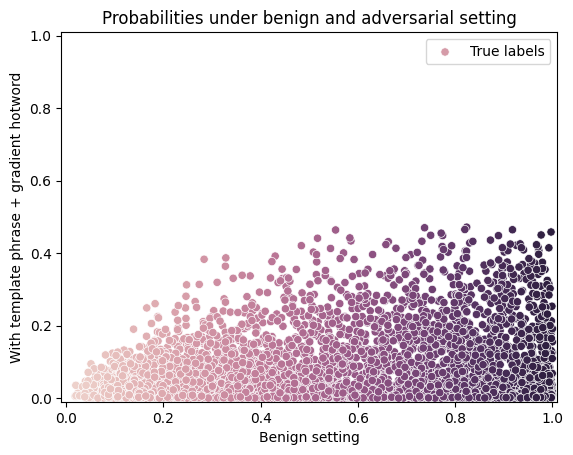

In [23]:
g = sns.scatterplot(data=df_prob_true_adv_real_baseline, x=df_prob_true_adv_real_baseline.columns[0], y=df_prob_true_adv_real_baseline.columns[1], hue=df_prob_true_adv_real_baseline.columns[0])
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["True labels"])
fig = g.get_figure()

min = df_prob_true_adv_real_baseline.min().min()
max = df_prob_true_adv_real_baseline.max().max()


g.set_xlim(min - 0.01,max + 0.01)
g.set_ylim(min - 0.01,max+ 0.01)

plt.show()
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_{real_baseline}_{adversarial}_{trigger_type}.jpg", dpi=500)

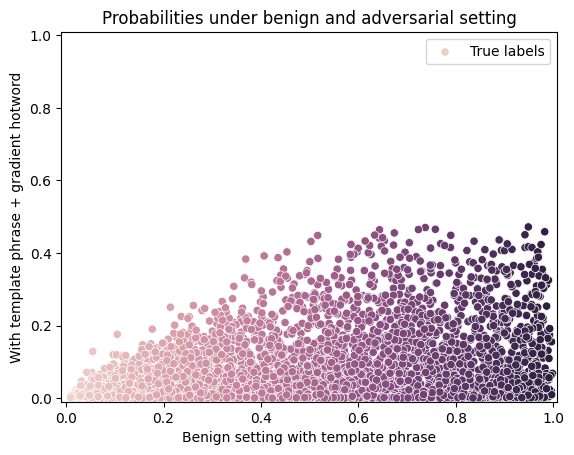

In [26]:
g = sns.scatterplot(data=df_prob_true_adv_template_baseline, x=df_prob_true_adv_template_baseline.columns[0], y=df_prob_true_adv_template_baseline.columns[1], hue=df_prob_true_adv_template_baseline.columns[0])
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["True labels"])
fig = g.get_figure()

min = df_prob_true_adv_template_baseline.min().min()
max = df_prob_true_adv_template_baseline.max().max()

g.set_xlim(min - 0.01,max + 0.01)
g.set_ylim(min - 0.01,max+ 0.01)

plt.show()
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_{template_baseline}_{adversarial}_{trigger_type}.jpg", dpi=500)

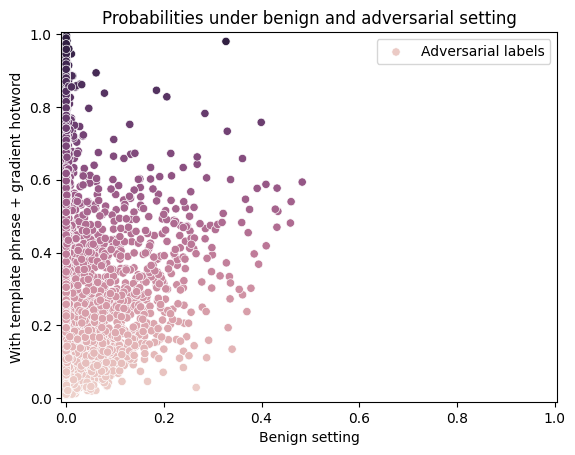

In [27]:
g = sns.scatterplot(data=df_prob_adv_labels_adversarial_real_template, x=df_prob_adv_labels_adversarial_real_template.columns[0], y=df_prob_adv_labels_adversarial_real_template.columns[2], hue=df_prob_adv_labels_adversarial_real_template.columns[2])
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["Adversarial labels"])
fig = g.get_figure()

min = df_prob_adv_labels_adversarial_real_template.min().min()
max = df_prob_adv_labels_adversarial_real_template.max().max()

g.set_xlim(min - 0.01,max + 0.01)
g.set_ylim(min - 0.01,max+ 0.01)

plt.show()
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_{adversarial}_{real_baseline}_{trigger_type}.jpg", dpi=500)

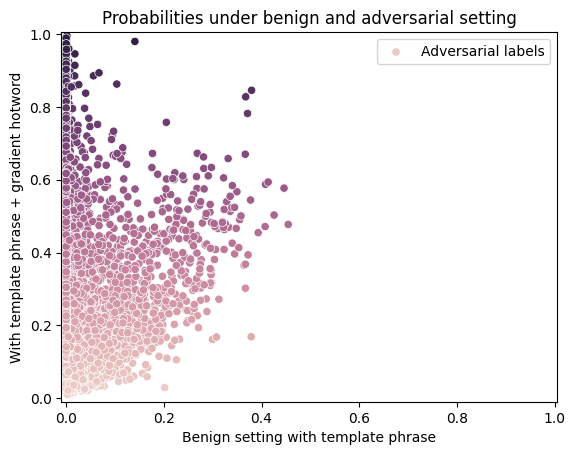

In [28]:
g = sns.scatterplot(data=df_prob_adv_labels_adversarial_real_template, x=df_prob_adv_labels_adversarial_real_template.columns[1], y=df_prob_adv_labels_adversarial_real_template.columns[2], hue=df_prob_adv_labels_adversarial_real_template.columns[2])
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["Adversarial labels"])
fig = g.get_figure()

min = df_prob_adv_labels_adversarial_real_template.min().min()
max = df_prob_adv_labels_adversarial_real_template.max().max()

g.set_xlim(min - 0.01,max + 0.01)
g.set_ylim(min - 0.01,max+ 0.01)


plt.show()
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_{adversarial}_{template_baseline}_{trigger_type}.jpg", dpi=500)

In [75]:
# Plotting deltas for real, template and adversarial settings

In [76]:
# Delta Real baseline and adversarial in baseline setting real and adversarial


#Prob(True) - Prob(Adv) in base
#Prob(Adv) - Prob(True) in adv


delta_real_baseline_adv_real_baseline = (np.asarray(prob_true_labels_real_baseline) - np.asarray(prob_adv_labels_real_baseline)) 
delta_real_baseline_adv_adversarial =  (np.asarray(prob_adv_labels_adversarial) - np.asarray(prob_true_labels_adv))

df_delta_real_baseline_adv_real_baseline = pd.DataFrame([delta_real_baseline_adv_real_baseline, delta_real_baseline_adv_adversarial]).T
df_delta_real_baseline_adv_real_baseline.columns = ['Benign setting', 'With gradient hotword + template phrase']

In [77]:
# Delta Real baseline and adversarial in baseline setting real and adversarial


#Prob(True) - Prob(Adv) in base_template
#Prob(Adv) - Prob(True) in adv


delta_template_baseline_adv_template_baseline = (np.asarray(prob_true_labels_template_baseline) - np.asarray(prob_adv_labels_template_baseline)) 
delta_template_baseline_adv_adversarial =  (np.asarray(prob_adv_labels_adversarial) - np.asarray(prob_true_labels_adv))

df_delta_template_baseline_adv_template_baseline = pd.DataFrame([delta_template_baseline_adv_template_baseline, delta_template_baseline_adv_adversarial]).T
df_delta_template_baseline_adv_template_baseline.columns = ['Benign setting with template phrase', 'With gradient hotword + template phrase']

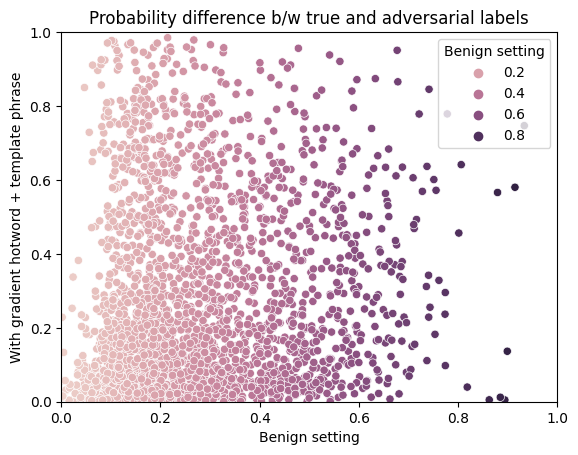

In [78]:
g = sns.scatterplot(data=df_delta_real_baseline_adv_real_baseline, x=df_delta_real_baseline_adv_real_baseline.columns[0], y=df_delta_real_baseline_adv_real_baseline.columns[1], hue=df_delta_real_baseline_adv_real_baseline.columns[0])
g.set_xlim(0,1)
g.set_ylim(0,1)
fig = g.get_figure() 
plt.title("Probability difference b/w true and adversarial labels")
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_delta_{real_baseline}_{adversarial}_{trigger_type}.jpg", dpi=500)

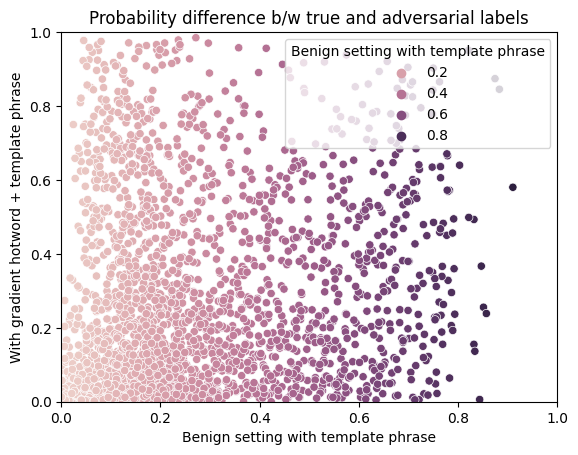

In [54]:
g = sns.scatterplot(data=df_delta_template_baseline_adv_template_baseline, x=df_delta_template_baseline_adv_template_baseline.columns[0], y=df_delta_template_baseline_adv_template_baseline.columns[1], hue=df_delta_template_baseline_adv_template_baseline.columns[0])
g.set_xlim(0,1)
g.set_ylim(0,1)
fig = g.get_figure() 
plt.title("Probability difference b/w true and adversarial labels")
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_delta_{template_baseline}_{adversarial}_{trigger_type}.jpg", dpi=500)

In [55]:
# Compute and print stats

In [56]:
# Raw stats
mean_true_labels_real_baseline = np.asarray(prob_true_labels_real_baseline).mean()
std_true_labels_real_baseline = np.asarray(prob_true_labels_real_baseline).std()

mean_true_labels_template_baseline = np.asarray(prob_true_labels_template_baseline).mean()
std_true_labels_template_baseline = np.asarray(prob_true_labels_template_baseline).std()

mean_true_labels_adversarial = np.asarray(prob_true_labels_adv).mean()
std_true_labels_adversarial = np.asarray(prob_true_labels_adv).std()


mean_adv_labels_real_baseline = np.asarray(prob_adv_labels_real_baseline).mean()
std_adv_labels_real_baseline = np.asarray(prob_adv_labels_real_baseline).std()

mean_adv_labels_template_baseline = np.asarray(prob_adv_labels_template_baseline).mean()
std_adv_labels_template_baseline = np.asarray(prob_adv_labels_template_baseline).std()

mean_adv_labels_adversarial = np.asarray(prob_adv_labels_adversarial).mean()
std_adv_labels_adversarial = np.asarray(prob_adv_labels_adversarial).std()

# Stats for deltas

mean_delta_real_baseline_adv_real_baseline = delta_real_baseline_adv_real_baseline.mean()
std_delta_real_baseline_adv_real_baseline = delta_real_baseline_adv_real_baseline.std()

mean_delta_real_baseline_adv_adversarial = delta_real_baseline_adv_adversarial.mean()
std_delta_real_baseline_adv_adversarial = delta_real_baseline_adv_adversarial.std()

mean_delta_template_baseline_adv_template_baseline = delta_template_baseline_adv_template_baseline.mean()
std_delta_template_baseline_adv_template_baseline = delta_template_baseline_adv_template_baseline.std()

mean_delta_template_baseline_adv_adversarial = delta_template_baseline_adv_adversarial.mean()
std_delta_template_baseline_adv_adversarial = delta_template_baseline_adv_adversarial.std()


In [57]:
print("Flip rate : ", flip_rate)
print(f"Total samples : {len(loaded_dict['results_adversarial']['all_first_success_ranks'])}")
print ("------------------------------------------------------------------------------------")
print("Raw Stats")
print ("------------------------------------------------------------------------------------")
print(f"\t Mean and dev for true labels in the real baseline is {mean_true_labels_real_baseline}, {std_true_labels_real_baseline}")
print(f"\t Mean and dev for true labels in the template baseline is {mean_true_labels_template_baseline}, {std_true_labels_template_baseline}")

print(f"\t Mean and dev for adversarial labels in the real baseline is {mean_adv_labels_real_baseline}, {std_adv_labels_real_baseline}")
print(f"\t Mean and dev for adversarial labels in the template baseline is {mean_adv_labels_template_baseline}, {std_adv_labels_template_baseline}")

print(f"\t Mean and dev for adversarial labels in the adversarial setting is {mean_adv_labels_adversarial}, {std_adv_labels_adversarial}")

print ("------------------------------------------------------------------------------------")
print("Stats for deltas")
print ("------------------------------------------------------------------------------------")
print(f"\t Mean and dev for deltas b/w true and adversarial labels's probs in real_baseline  {mean_delta_real_baseline_adv_real_baseline}, {std_delta_real_baseline_adv_real_baseline}")
print(f"\t Mean and dev for deltas b/w true and adversarial labels's probs in template_baseline  {mean_delta_template_baseline_adv_template_baseline}, {std_delta_template_baseline_adv_template_baseline}")

print(f"\t Mean and dev for deltas b/w true and adversarial labels's probs in adversarial setting  {mean_delta_template_baseline_adv_adversarial}, {std_delta_template_baseline_adv_adversarial}")


Flip rate :  0.9788
Total samples : 2500
------------------------------------------------------------------------------------
Raw Stats
------------------------------------------------------------------------------------
	 Mean and dev for true labels in the real baseline is 0.2986919910330698, 0.1653476647092502
	 Mean and dev for true labels in the template baseline is 0.2954329645248228, 0.1998848965211086
	 Mean and dev for adversarial labels in the real baseline is 0.02474494508519889, 0.043750192565948885
	 Mean and dev for adversarial labels in the template baseline is 0.030641854683744627, 0.049373927752285704
	 Mean and dev for adversarial labels in the adversarial setting is 0.320731462040725, 0.23097468592609438
------------------------------------------------------------------------------------
Stats for deltas
------------------------------------------------------------------------------------
	 Mean and dev for deltas b/w true and adversarial labels's probs in real_baseli

In [58]:
mean_delta_real_baseline_adv_adversarial

0.2662971917341064

# Template phrase + Optim Only (No TP in bsaeline)


In [5]:
numpy_file = "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_single_entity_with_without_template_phrase_shuffled_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_20_probs_new.npy"
loaded_dict = np.load(numpy_file, allow_pickle=True)
loaded_dict = loaded_dict.item()
trigger_type="template_optim"
benign_setting = 'with_template_optim_benign'
adversarial_setting = 'with_template_optim_adversarial'

In [47]:
all_first_success_probs = []
all_baseline_probs = []
all_true_labels = []
all_adv_labels = []
all_fail_indices = []
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        true_label = loaded_dict['results_adversarial']['all_labels_triggers'][i][0]
        adv_label = loaded_dict['results_adversarial']['all_pred_labels_triggers'][i][first_succ_rank][0]
        adv_probs = loaded_dict['results_adversarial']['all_probs_triggers'][i][first_succ_rank.item()]
        base_probs = loaded_dict["results_baseline_real"]['all_probs_base'][i]
        all_first_success_probs.append(adv_probs)
        all_baseline_probs.append(base_probs)
        all_true_labels.append(true_label)
        all_adv_labels.append(adv_label)
    else:
        all_fail_indices.append(i)
        

all_first_success_probs = [F.softmax(probs, dim=-1) for probs in all_first_success_probs]
all_baseline_probs = [F.softmax(probs, dim=-1) for probs in all_baseline_probs]

In [49]:
np.where(delta_benign < 0)

(array([  60, 1574]),)

In [46]:
np.where(delta_benign < 0)

(array([  60, 1574]),)

In [9]:
# Sorting predictions of base and adv (tokens and their predictions)
top_k = len(all_baseline_probs[0])

base_top_k = []
adv_top_k = []

probs, indices = torch.topk(all_baseline_probs[0], k=top_k, largest=True)
base_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_baseline_probs]
adv_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_first_success_probs]

In [10]:
# Track ranking of baseline top_1 before and after adversarial triggers
base_rank_prob_tracker = []
for i, label in enumerate(all_true_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    base_rank_prob_tracker.append(prob_rank_track)


In [11]:
# Track ranking of adv top_1 before and after adversarial triggers
adv_rank_prob_tracker = []
for i, label in enumerate(all_adv_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    adv_rank_prob_tracker.append(prob_rank_track)


In [12]:
# Compute entropy of top_10 predictions
# Saving Top-k predictions of base and adv (tokens and their predictions)
top_10 = 10

base_top_10 = []
adv_top_10 = []

base_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_baseline_probs]
base_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in base_top_10]
base_top_10 = [probs.detach().cpu().numpy() for probs in base_top_10]
base_entropies = [entropy(b_10, base=2) for b_10 in base_top_10]
base_entropies_median = np.median(base_entropies)
base_entropies_mean = np.mean(base_entropies)
base_entropies_dev = np.std(base_entropies)


adv_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_first_success_probs]
adv_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in adv_top_10]
adv_top_10 = [probs.detach().cpu().numpy() for probs in adv_top_10]
adv_entropies = [entropy(a_10, base=2) for a_10 in adv_top_10]
adv_entropies_median = np.median(adv_entropies)
adv_entropies_mean = np.mean(adv_entropies)
adv_entropies_dev = np.std(adv_entropies)

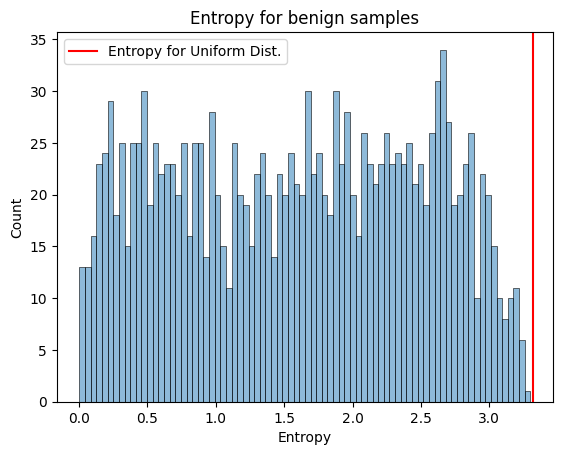

In [13]:
df_base_entropies = pd.DataFrame(base_entropies)
g = sns.histplot(data=df_base_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy for benign samples")
fig = g.get_figure()
#fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_{benign_setting}.jpg", dpi=500)




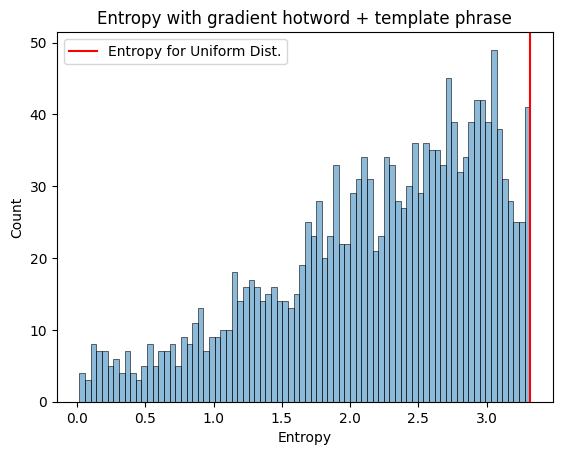

In [14]:
df_adv_entropies = pd.DataFrame(adv_entropies)
g = sns.histplot(data=df_adv_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy with gradient hotword + template phrase")
fig = g.get_figure()
#fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_{adversarial_setting}.jpg", dpi=500)




In [15]:
# Plotting losses ~ CE loss tells us how confident the model was for the correct prediction 
# Can do it for True and adversarial labels in both (baseline and adversarial examples) to get an understanding of the loss surface.


In [16]:
all_first_success_losses = []
all_baseline_losses = []
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        adv_loss = loaded_dict['results_adversarial']['all_losses_triggers'][i][first_succ_rank.item()]
        # Replace "results_baseline" with "results_baseline_real" 
        base_loss = loaded_dict['results_baseline_real']['all_losses_base'][i]
        all_first_success_losses.append(adv_loss.to("cpu").item())
        all_baseline_losses.append(base_loss.to("cpu").item())
        


In [17]:
# Compute and store the loss on the adversarial tokens when they were predicted as the correct labels 
all_losses_adversarial_tokens = []
for i in range(len(all_adv_labels)):
    adv_prob = all_first_success_probs[i][all_adv_labels[i]]
    loss_on_adv = torch.log(adv_prob)
    all_losses_adversarial_tokens.append(loss_on_adv.to("cpu").item())


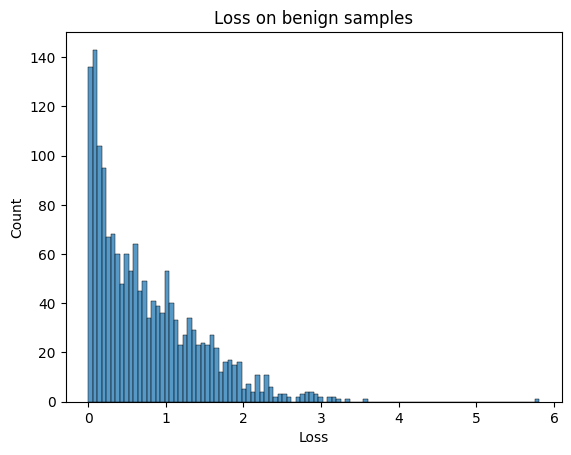

In [18]:
# Compute and store the delta between Top-1 and Top-2 prediction for baseline tokens
all_baseline_losses = [-loss for loss in all_baseline_losses] 
g = sns.histplot(data=all_baseline_losses, bins=100)
plt.xlabel("Loss")
plt.title("Loss on benign samples")
fig = g.get_figure()
#fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_{benign_setting}.jpg", dpi=500)



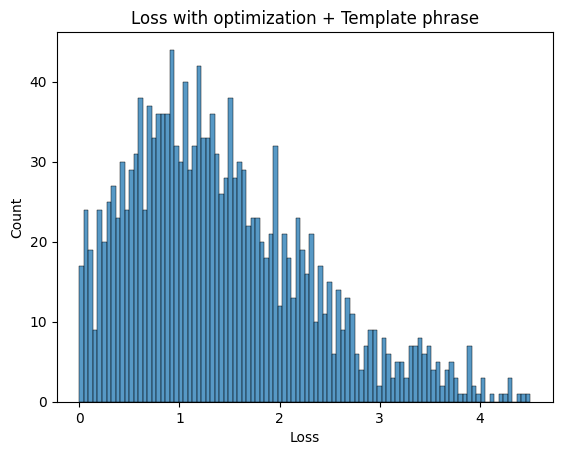

In [19]:
all_first_success_losses = [-loss for loss in all_first_success_losses]
all_losses_adversarial_tokens = [-loss for loss in all_losses_adversarial_tokens]
g = sns.histplot(data=all_losses_adversarial_tokens, bins=100)
plt.xlabel("Loss")
plt.title("Loss with optimization + Template phrase")
fig = g.get_figure()
#fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_{adversarial_setting}.jpg", dpi=500)



In [20]:
# Bucket probs into Top-1, Top 2-5, 5-10, 10-Infinity

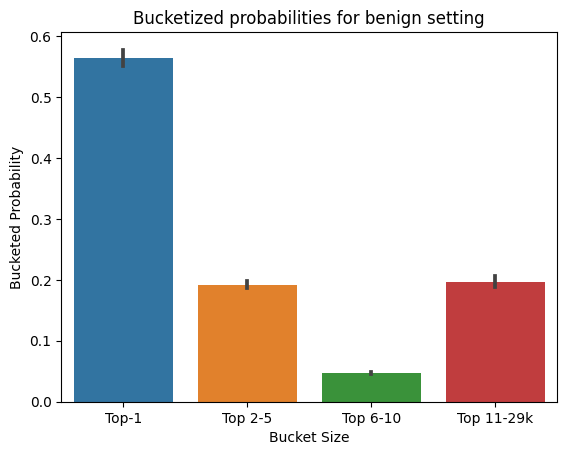

In [21]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_baseline_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_baseline_probs]
buckets_baseline = [[], [], [], []] 
for dist in all_baseline_probs_sorted_desc:
    buckets_baseline[0].append(dist[0].to("cpu").item())
    buckets_baseline[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_baseline[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_baseline[3].append(torch.sum(dist[11:]).to("cpu").item())


df_buckets_baseline = pd.DataFrame(buckets_baseline).T
df_buckets_baseline.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']


g = sns.barplot(data=df_buckets_baseline)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized probabilities for benign setting")
fig = g.get_figure()
#fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_{benign_setting}.jpg", dpi=500)



In [22]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_adv_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_first_success_probs]
buckets_adv = [[], [], [], []] 
for dist in all_adv_probs_sorted_desc:
    buckets_adv[0].append(dist[0].to("cpu").item())
    buckets_adv[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_adv[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_adv[3].append(torch.sum(dist[11:]).to("cpu").item())







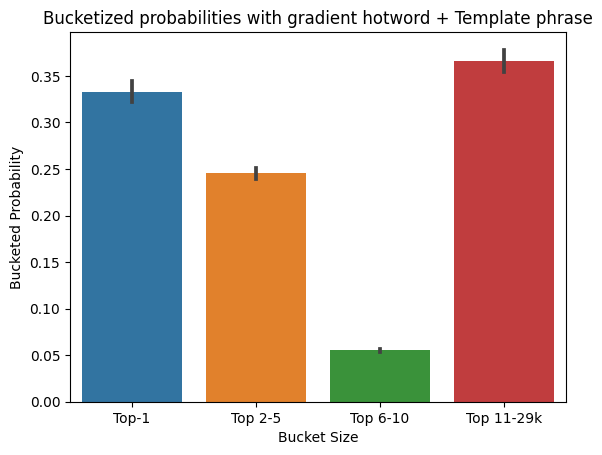

In [23]:
df_buckets_adv = pd.DataFrame(buckets_adv).T
df_buckets_adv.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']
g = sns.barplot(data=df_buckets_adv)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized probabilities with gradient hotword + Template phrase")
fig = g.get_figure()
#fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_{adversarial_setting}_Optim.jpg", dpi=500)


In [24]:
base_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in base_rank_prob_tracker]
base_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in base_rank_prob_tracker]

In [25]:
df_true_labels = pd.DataFrame([base_rank_prob_tracker_og, base_rank_prob_tracker_post]).T
df_true_labels.columns = ['Benign setting', 'With gradient hotword + template phrase']



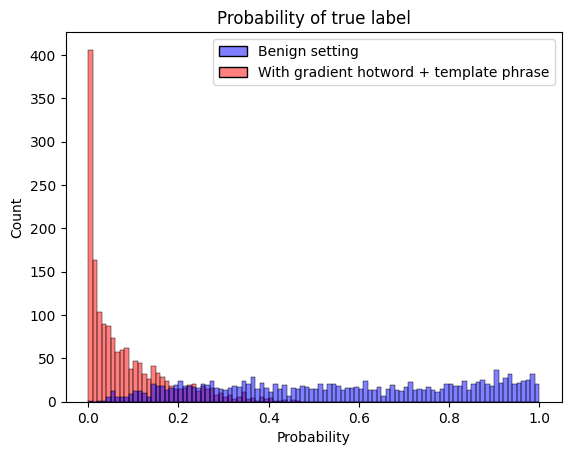

In [26]:
g = sns.histplot(data=df_true_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability of true label")
fig = g.get_figure()
#fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_{benign_setting}.jpg", dpi=500)



In [27]:
adv_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in adv_rank_prob_tracker]
adv_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in adv_rank_prob_tracker]

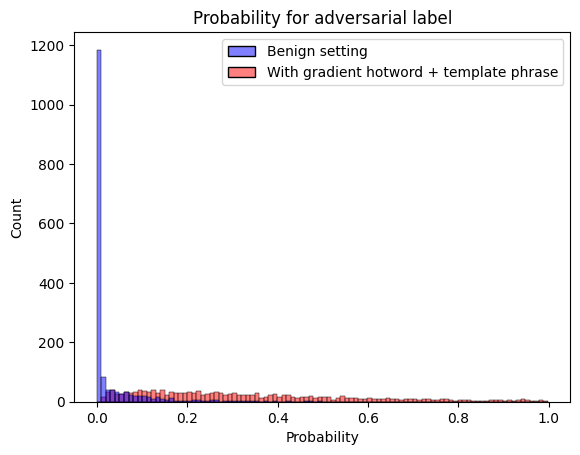

In [28]:
df_adv_labels = pd.DataFrame([adv_rank_prob_tracker_og, adv_rank_prob_tracker_post]).T
df_adv_labels.columns = ['Benign setting', 'With gradient hotword + template phrase']

g = sns.histplot(data=df_adv_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability for adversarial label")
fig = g.get_figure()
#fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_{adversarial_setting}.jpg", dpi=500)



In [29]:
# Compute and plot differences
delta_base_adv_benign = ((np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) / np.asarray(base_rank_prob_tracker_og))*100
delta_base_adv_adv =  ((np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post)) / np.asarray(adv_rank_prob_tracker_post))*100

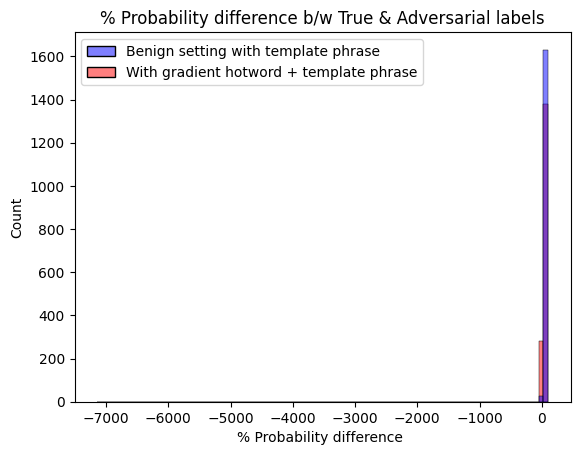

In [30]:
df_delta_base_adv_benign = pd.DataFrame([delta_base_adv_benign, delta_base_adv_adv]).T

df_delta_base_adv_benign.columns = ['Benign setting with template phrase', 'With gradient hotword + template phrase']

g = sns.histplot(data=df_delta_base_adv_benign, bins=100, palette=['blue', 'red'])
plt.xlabel("% Probability difference ")
plt.title("% Probability difference b/w True & Adversarial labels")
fig = g.get_figure()
#fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_delta_{trigger_type}.jpg", dpi=500)



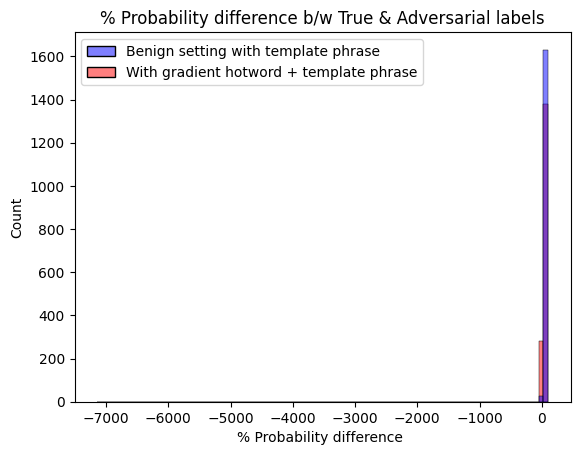

In [31]:
df_delta_base_adv_benign = pd.DataFrame([delta_base_adv_benign, delta_base_adv_adv]).T
df_delta_base_adv_benign.columns = ['Benign setting with template phrase', 'With gradient hotword + template phrase']

g = sns.histplot(data=df_delta_base_adv_benign, bins=100, palette=['blue', 'red'])
plt.xlabel("% Probability difference ")
plt.title("% Probability difference b/w True & Adversarial labels")
fig = g.get_figure()
#fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_delta_{trigger_type}.jpg", dpi=500)



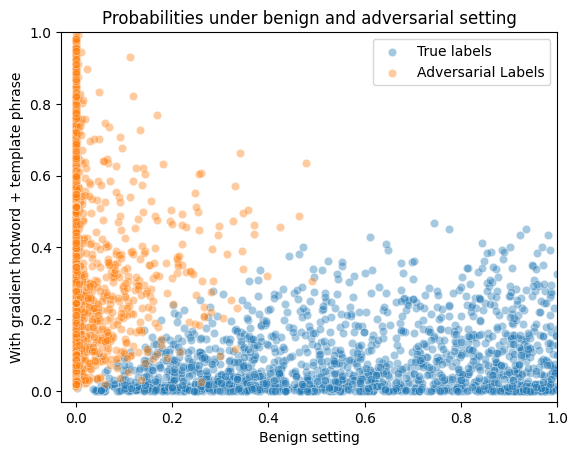

In [32]:
g = sns.scatterplot(data=df_true_labels, x=df_true_labels.columns[0], y=df_true_labels.columns[1], alpha=0.4)
g = sns.scatterplot(data=df_adv_labels, x=df_adv_labels.columns[0], y=df_adv_labels.columns[1], alpha=0.4)
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["True labels","Adversarial Labels"])
g.set_xlim(-0.03,1)
g.set_ylim(-0.03,1)
fig = g.get_figure()
plt.show()
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_{trigger_type}.jpg", dpi=500)

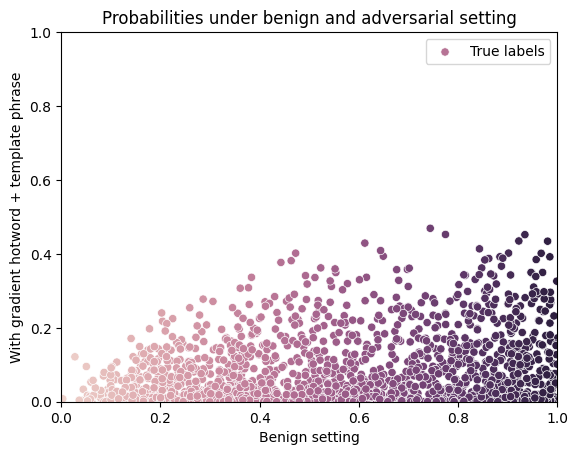

In [33]:
g = sns.scatterplot(data=df_true_labels, x=df_true_labels.columns[0], y=df_true_labels.columns[1], hue=df_true_labels.columns[0])
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["True labels"])
fig = g.get_figure()
g.set_xlim(0,1)
g.set_ylim(0,1)
plt.show()
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_{benign_setting}.jpg", dpi=500)

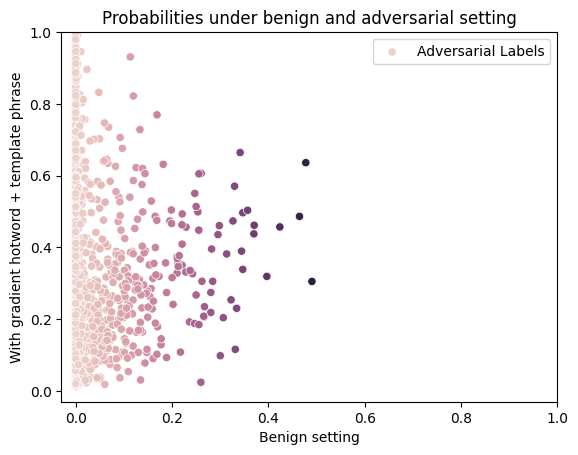

In [34]:
g = sns.scatterplot(data=df_adv_labels, x=df_adv_labels.columns[0], y=df_adv_labels.columns[1], hue=df_adv_labels.columns[0])
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["Adversarial Labels"])
fig = g.get_figure()
g.set_xlim(-0.03,1)
g.set_ylim(-0.03,1)
plt.show()
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_{adversarial_setting}.jpg", dpi=500)

In [35]:
# Compute and plot differences
delta_benign = (np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) 
delta_adv =  (np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post))

In [36]:
df_delta = pd.DataFrame([delta_benign, delta_adv]).T
df_delta.columns = ['Benign setting', 'With gradient hotword + template phrase']

In [37]:
# Compute and plot differences
delta_benign_percent = ((np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) / np.asarray(base_rank_prob_tracker_og))*100
delta_adv_percent =  ((np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post)) / np.asarray(adv_rank_prob_tracker_post))*100

In [38]:
df_delta_percent = pd.DataFrame([delta_benign_percent, delta_adv_percent]).T
df_delta_percent.columns = ['Benign setting', 'With gradient hotword + template phrase']

(array([], dtype=int64),)

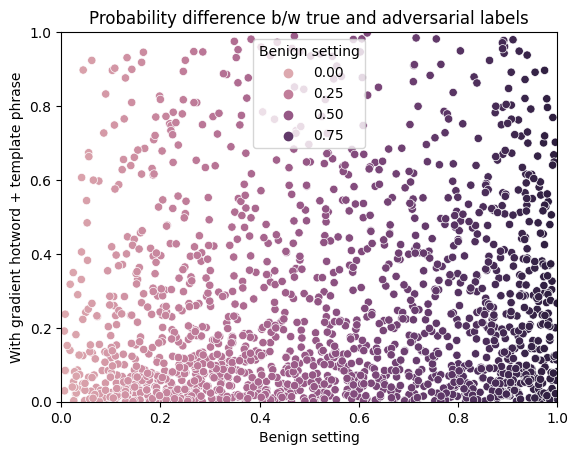

In [39]:
g = sns.scatterplot(data=df_delta, x=df_delta.columns[0], y=df_delta.columns[1], hue=df_delta.columns[0])
g.set_xlim(0,1)
g.set_ylim(0,1)
fig = g.get_figure() 
plt.title("Probability difference b/w true and adversarial labels")
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_{trigger_type}.jpg", dpi=500)

In [40]:
min(df_delta_percent[df_delta_percent.columns[0]])

-7144.974745267419

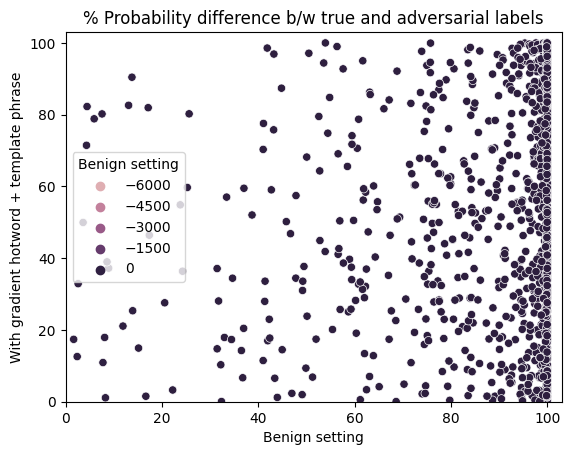

In [41]:
g = sns.scatterplot(data=df_delta_percent, x=df_delta.columns[0], y=df_delta.columns[1], hue=df_delta_percent.columns[0])
g.set_xlim(0,103)
g.set_ylim(0,103)
fig = g.get_figure()
plt.title("% Probability difference b/w true and adversarial labels")
fig.savefig(f"/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_delta_{trigger_type}.jpg", dpi=500)

In [99]:

mean_base_og = np.mean(base_rank_prob_tracker_og)
std_base_og = np.std(base_rank_prob_tracker_og)

mean_base_post = np.mean(base_rank_prob_tracker_post)
std_base_post = np.std(base_rank_prob_tracker_post)

print("Mean base OG : ", mean_base_og, "Std base OG : ", std_base_og)
print("Mean base Post : ", mean_base_post, "Std base Post : ", std_base_post)


mean_adv_og = np.mean(adv_rank_prob_tracker_og)
std_adv_og = np.std(adv_rank_prob_tracker_og)

mean_adv_post = np.mean(adv_rank_prob_tracker_post)
std_adv_post = np.std(adv_rank_prob_tracker_post)

print("Mean adv OG : ", mean_adv_og, "Std adv OG : ", std_adv_og)
print("Mean adv Post : ", mean_adv_post, "Std adv Post : ", std_adv_post)

mean_delta_benign = np.mean(delta_benign)
std_delta_benign = np.std(delta_benign)

mean_delta_benign_percent = np.std(delta_benign_percent)
std_delta_benign_percent = np.std(delta_benign_percent)

print("Mean diff b/w true adv labels in benign setting is : ", mean_delta_benign, " and dev is ", std_delta_benign)
print("Mean % diff b/w true adv labels in benign setting is : ", mean_delta_benign_percent, " and dev is ", std_delta_benign_percent)


mean_delta_adv = np.mean(delta_adv)
std_delta_adv = np.std(delta_adv)

mean_delta_adv_percent = np.std(delta_adv_percent)
std_delta_adv_percent = np.std(delta_adv_percent)

print("Mean diff b/w true adv labels in benign setting is : ", mean_delta_adv, " and dev is ", std_delta_adv)
print("Mean % diff b/w true adv labels in benign setting is : ", mean_delta_adv_percent, " and dev is ", std_delta_adv_percent)





Mean base OG :  0.2992822970995712 Std base OG :  0.16512700613812525
Mean base Post :  0.05425769747556619 Std base Post :  0.05780500544103449
Mean adv OG :  0.02544470176687803 Std adv OG :  0.04539769169471474
Mean adv Post :  0.3203875188228608 Std adv Post :  0.2305204001205593
Mean diff b/w true adv labels in benign setting is :  0.2738375953326932  and dev is  0.16562730364451422
Mean % diff b/w true adv labels in benign setting is :  17.197015904844214  and dev is  17.197015904844214
Mean diff b/w true adv labels in benign setting is :  0.2661298213472947  and dev is  0.2515615278798031
Mean % diff b/w true adv labels in benign setting is :  30.374393852617008  and dev is  30.374393852617008


# Template phrase + Optim Only (TP in baseline)


In [3]:
numpy_file = "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/correctly_classified_bert_large_cased_single_entity_extended_phrase_bert-large-cased_gpt_false_adv_token_true_remove_periods_false_add_comma_false_attempts_20_probs.npy"
loaded_dict = np.load(numpy_file, allow_pickle=True)
loaded_dict = loaded_dict.item()


In [4]:
all_first_success_probs = []
all_baseline_probs = []
all_true_labels = []
all_adv_labels = []
inc=0
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        true_label = loaded_dict['results_adversarial']['all_labels_triggers'][i][0]
        adv_label = loaded_dict['results_adversarial']['all_pred_labels_triggers'][i][first_succ_rank][0]
        adv_probs = loaded_dict['results_adversarial']['all_probs_triggers'][i][first_succ_rank.item()]
        base_probs = loaded_dict["results_baseline_real"]['all_probs_base'][i]
        all_first_success_probs.append(adv_probs)
        all_baseline_probs.append(base_probs)
        all_true_labels.append(true_label)
        all_adv_labels.append(adv_label)
    else:
        inc+=1
        

all_first_success_probs = [F.softmax(probs, dim=-1) for probs in all_first_success_probs]
all_baseline_probs = [F.softmax(probs, dim=-1) for probs in all_baseline_probs]

In [5]:
# Sorting predictions of base and adv (tokens and their predictions)
top_k = len(all_baseline_probs[0])

base_top_k = []
adv_top_k = []

probs, indices = torch.topk(all_baseline_probs[0], k=top_k, largest=True)
base_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_baseline_probs]
adv_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_first_success_probs]

In [6]:
# Track ranking of baseline top_1 before and after adversarial triggers
base_rank_prob_tracker = []
for i, label in enumerate(all_true_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    base_rank_prob_tracker.append(prob_rank_track)


In [7]:
# Track ranking of adv top_1 before and after adversarial triggers
adv_rank_prob_tracker = []
for i, label in enumerate(all_adv_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    adv_rank_prob_tracker.append(prob_rank_track)


In [8]:
# Actual analysis starts

In [9]:
# Compute entropy of top_10 predictions
# Saving Top-k predictions of base and adv (tokens and their predictions)
top_10 = 10

base_top_10 = []
adv_top_10 = []

base_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_baseline_probs]
base_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in base_top_10]
base_top_10 = [probs.detach().cpu().numpy() for probs in base_top_10]
base_entropies = [entropy(b_10, base=2) for b_10 in base_top_10]
base_entropies_median = np.median(base_entropies)
base_entropies_mean = np.mean(base_entropies)
base_entropies_dev = np.std(base_entropies)


adv_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_first_success_probs]
adv_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in adv_top_10]
adv_top_10 = [probs.detach().cpu().numpy() for probs in adv_top_10]
adv_entropies = [entropy(a_10, base=2) for a_10 in adv_top_10]
adv_entropies_median = np.median(adv_entropies)
adv_entropies_mean = np.mean(adv_entropies)
adv_entropies_dev = np.std(adv_entropies)

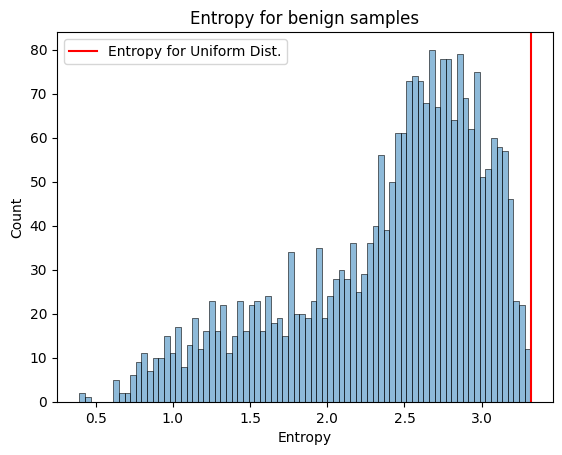

In [10]:
df_base_entropies = pd.DataFrame(base_entropies)
g = sns.histplot(data=df_base_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy for benign samples")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Baseline.jpg", dpi=500)




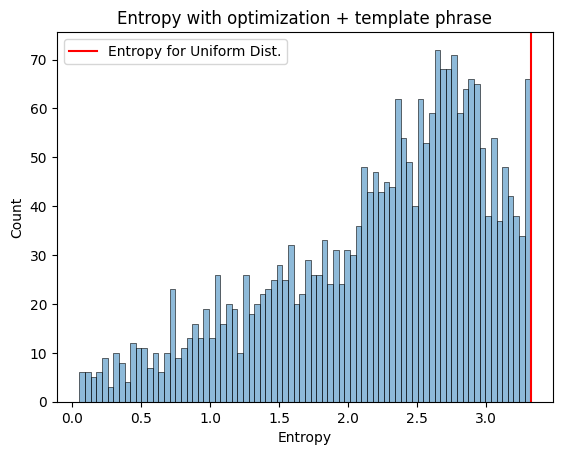

In [11]:
df_adv_entropies = pd.DataFrame(adv_entropies)
g = sns.histplot(data=df_adv_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy with optimization + template phrase")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Adv_Only_Optim.jpg", dpi=500)




In [12]:
# Plotting losses ~ CE loss tells us how confident the model was for the correct prediction 
# Can do it for True and adversarial labels in both (baseline and adversarial examples) to get an understanding of the loss surface.


In [13]:
all_first_success_losses = []
all_baseline_losses = []
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        adv_loss = loaded_dict['results_adversarial']['all_losses_triggers'][i][first_succ_rank.item()]
        # Replace "results_baseline" with "results_baseline_real" 
        base_loss = loaded_dict['results_baseline_real']['all_losses_base'][i]
        all_first_success_losses.append(adv_loss.to("cpu").item())
        all_baseline_losses.append(base_loss.to("cpu").item())
        


In [14]:
# Compute and store the loss on the adversarial tokens when they were predicted as the correct labels 
all_losses_adversarial_tokens = []
for i in range(len(all_adv_labels)):
    adv_prob = all_first_success_probs[i][all_adv_labels[i]]
    loss_on_adv = torch.log(adv_prob)
    all_losses_adversarial_tokens.append(loss_on_adv.to("cpu").item())


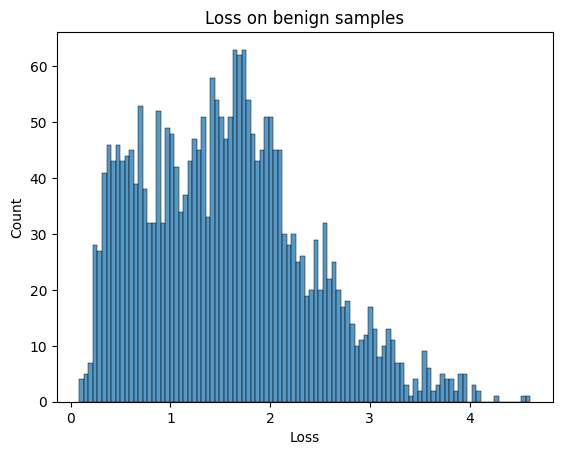

In [15]:
# Compute and store the delta between Top-1 and Top-2 prediction for baseline tokens
all_baseline_losses = [-loss for loss in all_baseline_losses] 
g = sns.histplot(data=all_baseline_losses, bins=100)
plt.xlabel("Loss")
plt.title("Loss on benign samples")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Baseline.jpg", dpi=500)



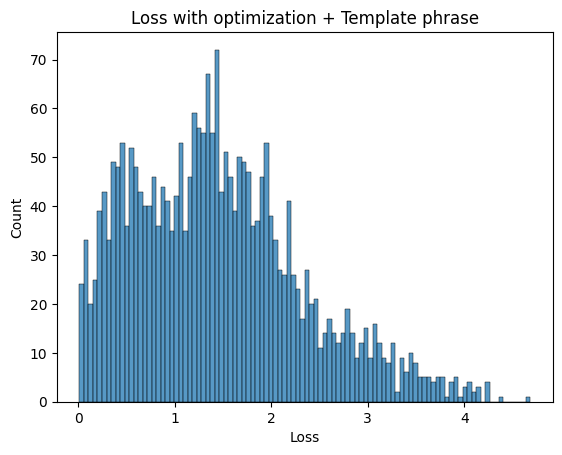

In [16]:
all_first_success_losses = [-loss for loss in all_first_success_losses]
all_losses_adversarial_tokens = [-loss for loss in all_losses_adversarial_tokens]
g = sns.histplot(data=all_losses_adversarial_tokens, bins=100)
plt.xlabel("Loss")
plt.title("Loss with optimization + Template phrase")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Adversarial_Only_Optim.jpg", dpi=500)



In [17]:
# Bucket probs into Top-1, Top 2-5, 5-10, 10-Infinity

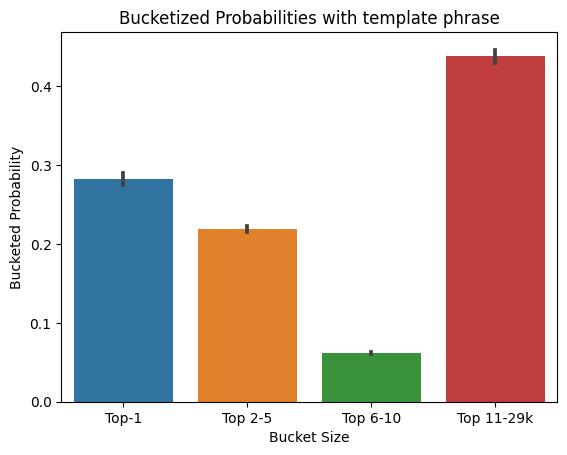

In [18]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_baseline_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_baseline_probs]
buckets_baseline = [[], [], [], []] 
for dist in all_baseline_probs_sorted_desc:
    buckets_baseline[0].append(dist[0].to("cpu").item())
    buckets_baseline[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_baseline[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_baseline[3].append(torch.sum(dist[11:]).to("cpu").item())


df_buckets_baseline = pd.DataFrame(buckets_baseline).T
df_buckets_baseline.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']


g = sns.barplot(data=df_buckets_baseline)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities with template phrase")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Baseline.jpg", dpi=500)



In [19]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_adv_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_first_success_probs]
buckets_adv = [[], [], [], []] 
for dist in all_adv_probs_sorted_desc:
    buckets_adv[0].append(dist[0].to("cpu").item())
    buckets_adv[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_adv[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_adv[3].append(torch.sum(dist[11:]).to("cpu").item())







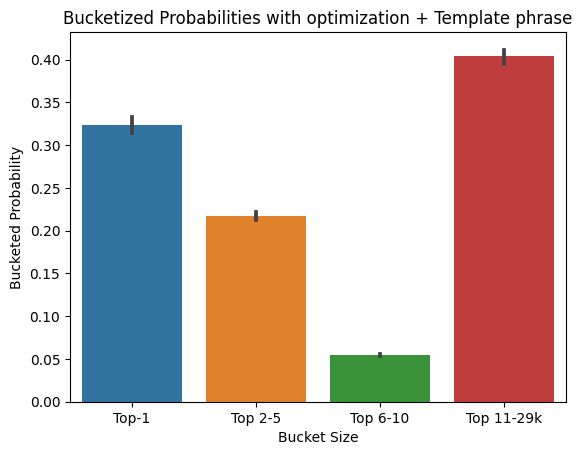

In [20]:
df_buckets_adv = pd.DataFrame(buckets_adv).T
df_buckets_adv.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']
g = sns.barplot(data=df_buckets_adv)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities with optimization + Template phrase")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Adv_Only_Optim.jpg", dpi=500)


In [21]:
base_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in base_rank_prob_tracker]
base_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in base_rank_prob_tracker]

In [22]:
df_true_labels = pd.DataFrame([base_rank_prob_tracker_og, base_rank_prob_tracker_post]).T
df_true_labels.columns = ['Benign setting with template phrase', 'With gradient hotword + template phrase']



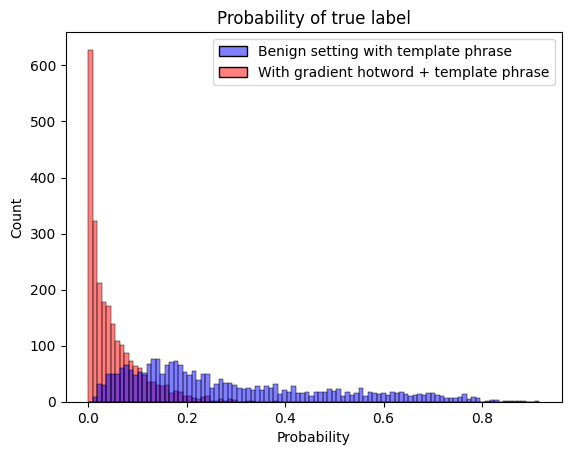

In [23]:
g = sns.histplot(data=df_true_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability of true label")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_base_optim.jpg", dpi=500)



In [24]:
adv_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in adv_rank_prob_tracker]
adv_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in adv_rank_prob_tracker]

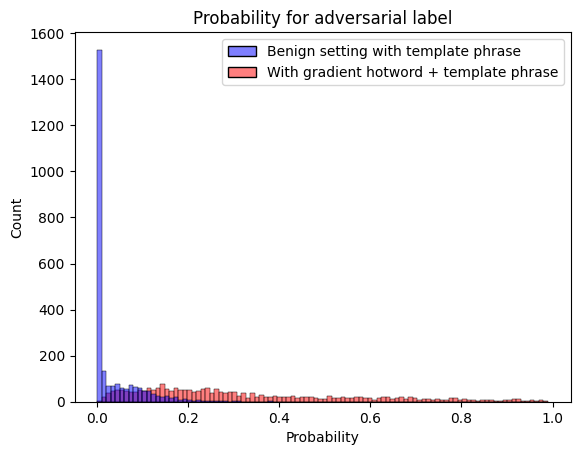

In [25]:
df_adv_labels = pd.DataFrame([adv_rank_prob_tracker_og, adv_rank_prob_tracker_post]).T
df_adv_labels.columns = ['Benign setting with template phrase', 'With gradient hotword + template phrase']

g = sns.histplot(data=df_adv_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability for adversarial label")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_base_optim.jpg", dpi=500)



In [26]:
# Compute and plot differences
delta_base_adv_benign = ((np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) / np.asarray(base_rank_prob_tracker_og))*100
delta_base_adv_adv =  ((np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post)) / np.asarray(adv_rank_prob_tracker_post))*100

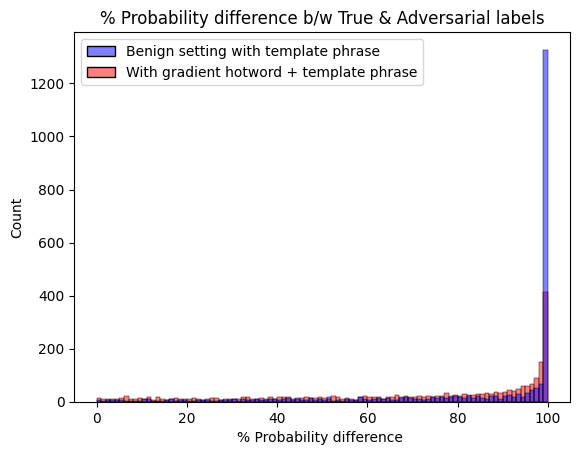

In [27]:
df_delta_base_adv_benign = pd.DataFrame([delta_base_adv_benign, delta_base_adv_adv]).T
df_delta_base_adv_benign.columns = ['Benign setting with template phrase', 'With gradient hotword + template phrase']

g = sns.histplot(data=df_delta_base_adv_benign, bins=100, palette=['blue', 'red'])
plt.xlabel("% Probability difference ")
plt.title("% Probability difference b/w True & Adversarial labels")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_delta_optim.jpg", dpi=500)



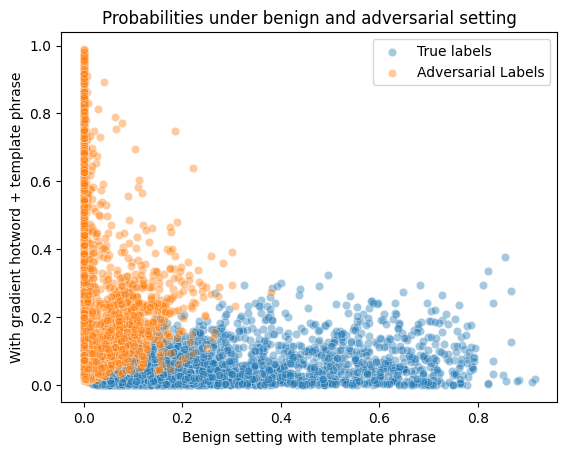

In [28]:
g = sns.scatterplot(data=df_true_labels, x=df_true_labels.columns[0], y=df_true_labels.columns[1], alpha=0.4)
g = sns.scatterplot(data=df_adv_labels, x=df_adv_labels.columns[0], y=df_adv_labels.columns[1], alpha=0.4)
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["True labels","Adversarial Labels"])
fig = g.get_figure()
plt.show()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_optim_tp.jpg", dpi=500)

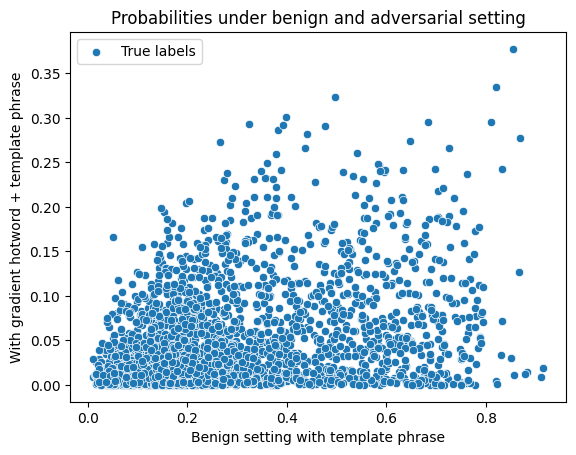

In [29]:
g = sns.scatterplot(data=df_true_labels, x=df_true_labels.columns[0], y=df_true_labels.columns[1])

plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["True labels"])
fig = g.get_figure()
plt.show()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_optim_true_tp.jpg", dpi=500)

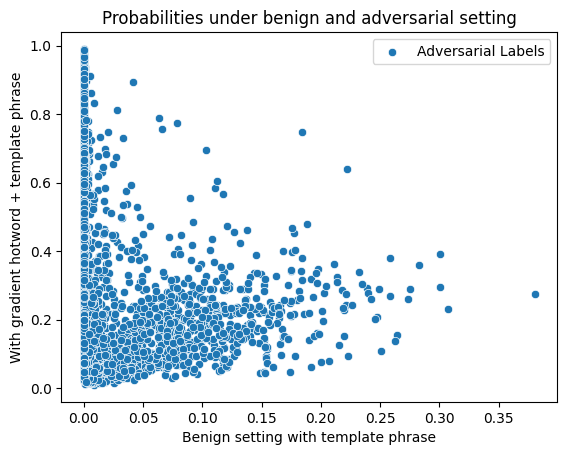

In [30]:
g = sns.scatterplot(data=df_adv_labels, x=df_adv_labels.columns[0], y=df_adv_labels.columns[1])
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["Adversarial Labels"])
fig = g.get_figure()
plt.show()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_optim_adv_tp.jpg", dpi=500)

In [31]:
# Compute and plot differences
delta_benign = (np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) 
delta_adv =  (np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post))

In [32]:
df_delta = pd.DataFrame([delta_benign, delta_adv]).T
df_delta.columns = ['Benign setting with template phrase', 'With gradient hotword + template phrase']

In [33]:
# Compute and plot differences
delta_benign_percent = ((np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) / np.asarray(base_rank_prob_tracker_og))*100
delta_adv_percent =  ((np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post)) / np.asarray(adv_rank_prob_tracker_post))*100

In [34]:
df_delta_percent = pd.DataFrame([delta_benign_percent, delta_adv_percent]).T
df_delta_percent.columns = ['Benign setting with template phrase', 'With gradient hotword + template phrase']

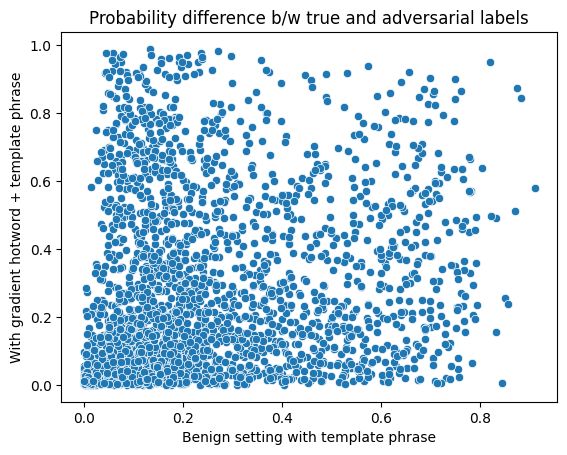

In [35]:
g = sns.scatterplot(data=df_delta, x=df_delta.columns[0], y=df_delta.columns[1])
fig = g.get_figure()
plt.title("Probability difference b/w true and adversarial labels")
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_delta_optim_tp.jpg", dpi=500)

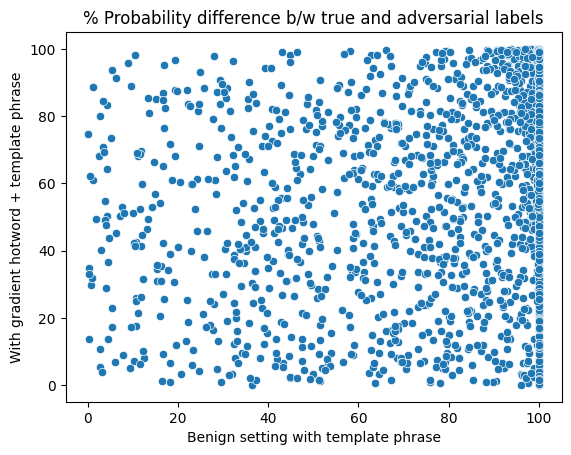

In [36]:
g = sns.scatterplot(data=df_delta_percent, x=df_delta.columns[0], y=df_delta.columns[1])
fig = g.get_figure()
plt.title("% Probability difference b/w true and adversarial labels")
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_delta_percent_optim_tp.jpg", dpi=500)

In [37]:

mean_base_og = np.mean(base_rank_prob_tracker_og)
std_base_og = np.std(base_rank_prob_tracker_og)

mean_base_post = np.mean(base_rank_prob_tracker_post)
std_base_post = np.std(base_rank_prob_tracker_post)

print("Mean base OG : ", mean_base_og, "Std base OG : ", std_base_og)
print("Mean base Post : ", mean_base_post, "Std base Post : ", std_base_post)


mean_adv_og = np.mean(adv_rank_prob_tracker_og)
std_adv_og = np.std(adv_rank_prob_tracker_og)

mean_adv_post = np.mean(adv_rank_prob_tracker_post)
std_adv_post = np.std(adv_rank_prob_tracker_post)

print("Mean adv OG : ", mean_adv_og, "Std adv OG : ", std_adv_og)
print("Mean adv Post : ", mean_adv_post, "Std adv Post : ", std_adv_post)

mean_delta_benign = np.mean(delta_benign)
std_delta_benign = np.std(delta_benign)

mean_delta_benign_percent = np.std(delta_benign_percent)
std_delta_benign_percent = np.std(delta_benign_percent)

print("Mean diff b/w true adv labels in benign setting is : ", mean_delta_benign, " and dev is ", std_delta_benign)
print("Mean % diff b/w true adv labels in benign setting is : ", mean_delta_benign_percent, " and dev is ", std_delta_benign_percent)


mean_delta_adv = np.mean(delta_adv)
std_delta_adv = np.std(delta_adv)

mean_delta_adv_percent = np.std(delta_adv_percent)
std_delta_adv_percent = np.std(delta_adv_percent)

print("Mean diff b/w true adv labels in benign setting is : ", mean_delta_adv, " and dev is ", std_delta_adv)
print("Mean % diff b/w true adv labels in benign setting is : ", mean_delta_adv_percent, " and dev is ", std_delta_adv_percent)





Mean base OG :  0.2820625688026907 Std base OG :  0.20180219464098317
Mean base Post :  0.050154143397830114 Std base Post :  0.05536715866051769
Mean adv OG :  0.031137264585891604 Std adv OG :  0.05240164585203426
Mean adv Post :  0.3235870127012033 Std adv Post :  0.23658210240172284
Mean diff b/w true adv labels in benign setting is :  0.2509253042167991  and dev is  0.2053835126016152
Mean % diff b/w true adv labels in benign setting is :  25.244079203919785  and dev is  25.244079203919785
Mean diff b/w true adv labels in benign setting is :  0.2734328693033732  and dev is  0.2565897082793669
Mean % diff b/w true adv labels in benign setting is :  30.047770310615483  and dev is  30.047770310615483


# GPT + Optimization

In [4]:
numpy_file = "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/bert_large_cased_2500_bert-large-cased_gpt_true_adv_token_true_remove_periods_false_add_comma_true_attempts_20_probs.npy"
loaded_dict = np.load(numpy_file, allow_pickle=True)
loaded_dict = loaded_dict.item()


In [5]:
all_first_success_probs = []
all_baseline_probs = []
all_true_labels = []
all_adv_labels = []
inc=0
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        true_label = loaded_dict['results_adversarial']['all_labels_triggers'][i][0]
        adv_label = loaded_dict['results_adversarial']['all_pred_labels_triggers'][i][first_succ_rank][0]
        adv_probs = loaded_dict['results_adversarial']['all_probs_triggers'][i][first_succ_rank.item()]
        base_probs = loaded_dict["results_baseline_real"]['all_probs_base'][i]
        all_first_success_probs.append(adv_probs)
        all_baseline_probs.append(base_probs)
        all_true_labels.append(true_label)
        all_adv_labels.append(adv_label)
    else:
        inc+=1
        

all_first_success_probs = [F.softmax(probs, dim=-1) for probs in all_first_success_probs]
all_baseline_probs = [F.softmax(probs, dim=-1) for probs in all_baseline_probs]

In [6]:
# Sorting predictions of base and adv (tokens and their predictions)
top_k = len(all_baseline_probs[0])

base_top_k = []
adv_top_k = []

probs, indices = torch.topk(all_baseline_probs[0], k=top_k, largest=True)
base_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_baseline_probs]
adv_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_first_success_probs]

In [7]:
# Track ranking of baseline top_1 before and after adversarial triggers
base_rank_prob_tracker = []
for i, label in enumerate(all_true_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    base_rank_prob_tracker.append(prob_rank_track)


In [8]:
# Track ranking of adv top_1 before and after adversarial triggers
adv_rank_prob_tracker = []
for i, label in enumerate(all_adv_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    adv_rank_prob_tracker.append(prob_rank_track)


In [9]:
  # Compute entropy of top_10 predictions

In [10]:
# Saving Top-k predictions of base and adv (tokens and their predictions)
top_10 = 10

base_top_10 = []
adv_top_10 = []

base_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_baseline_probs]
base_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in base_top_10]
base_top_10 = [probs.detach().cpu().numpy() for probs in base_top_10]
base_entropies = [entropy(b_10, base=2) for b_10 in base_top_10]
base_entropies_median = np.median(base_entropies)
base_entropies_mean = np.mean(base_entropies)
base_entropies_dev = np.std(base_entropies)


adv_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_first_success_probs]
adv_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in adv_top_10]
adv_top_10 = [probs.detach().cpu().numpy() for probs in adv_top_10]
adv_entropies = [entropy(a_10, base=2) for a_10 in adv_top_10]
adv_entropies_median = np.median(adv_entropies)
adv_entropies_mean = np.mean(adv_entropies)
adv_entropies_dev = np.std(adv_entropies)

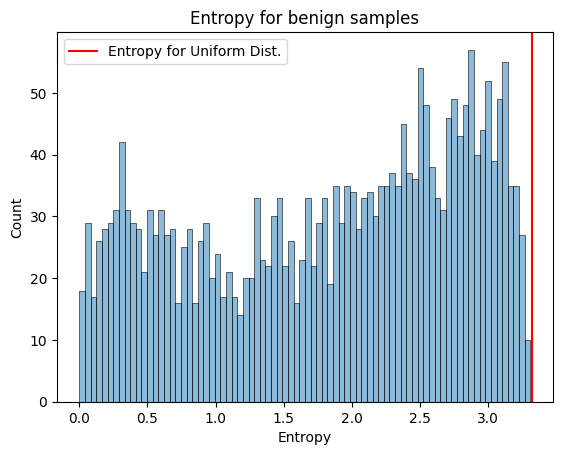

In [11]:
df_base_entropies = pd.DataFrame(base_entropies)
g = sns.histplot(data=df_base_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy for benign samples")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Baseline.jpg", dpi=500)




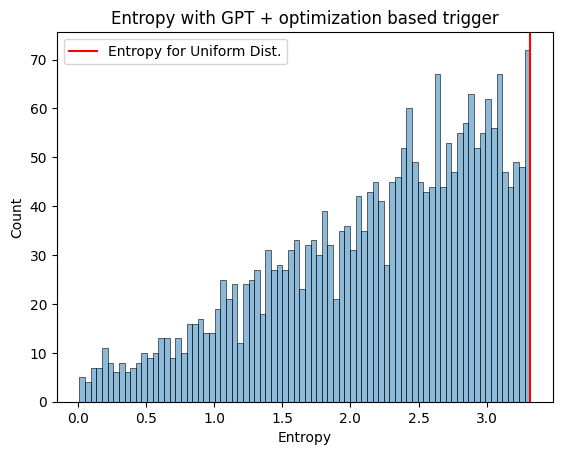

In [12]:
df_adv_entropies = pd.DataFrame(adv_entropies)
g = sns.histplot(data=df_adv_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy with GPT + optimization based trigger")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Adv_GPT_Optim.jpg", dpi=500)




In [13]:
# Plotting losses ~ CE loss tells us how confident the model was for the correct prediction 
# Can do it for True and adversarial labels in both (baseline and adversarial examples) to get an understanding of the loss surface.


In [14]:
all_first_success_losses = []
all_baseline_losses = []
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        adv_loss = loaded_dict['results_adversarial']['all_losses_triggers'][i][first_succ_rank.item()]
        # Replace "results_baseline" with "results_baseline_real" 
        base_loss = loaded_dict['results_baseline_real']['all_losses_base'][i]
        all_first_success_losses.append(adv_loss.to("cpu").item())
        all_baseline_losses.append(base_loss.to("cpu").item())
        


In [15]:
# Compute and store the loss on the adversarial tokens when they were predicted as the correct labels 
all_losses_adversarial_tokens = []
for i in range(len(all_adv_labels)):
    adv_prob = all_first_success_probs[i][all_adv_labels[i]]
    loss_on_adv = torch.log(adv_prob)
    all_losses_adversarial_tokens.append(loss_on_adv.to("cpu").item())


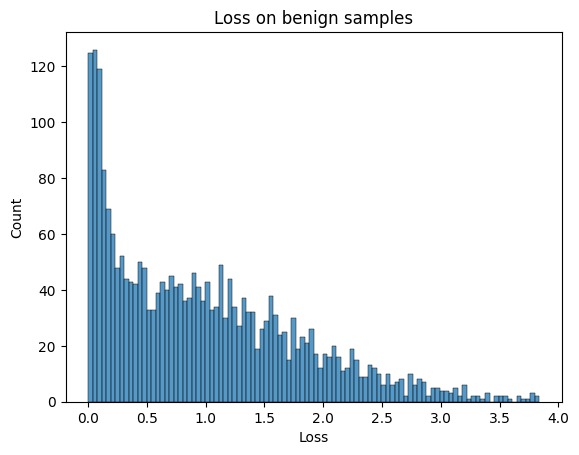

In [16]:
# Compute and store the delta between Top-1 and Top-2 prediction for baseline tokens
 
all_baseline_losses = [-loss for loss in all_baseline_losses]
g = sns.histplot(data=all_baseline_losses, bins=100)
plt.xlabel("Loss")
plt.title("Loss on benign samples")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Baseline_GPT_Optim.jpg", dpi=500)



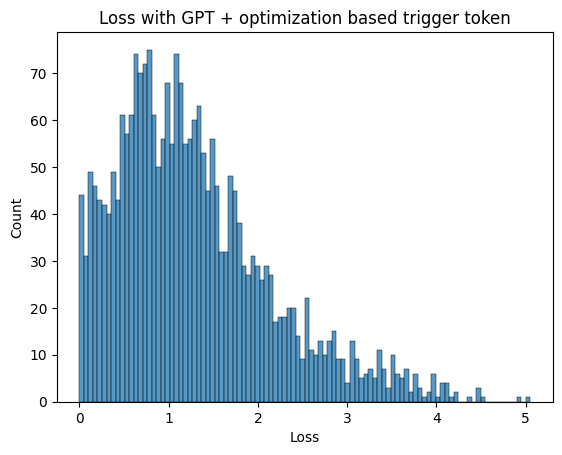

In [17]:
all_first_success_losses = [-loss for loss in all_first_success_losses]
all_losses_adversarial_tokens = [-loss for loss in all_losses_adversarial_tokens]
g = sns.histplot(data=all_losses_adversarial_tokens, bins=100)
plt.xlabel("Loss")
plt.title("Loss with GPT + optimization based trigger token")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Adversarial_GPT_Optim.jpg", dpi=500)



In [18]:
# Bucket probs into Top-1, Top 2-5, 5-10, 10-Infinity

In [19]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_baseline_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_baseline_probs]
buckets_baseline = [[], [], [], []] 
for dist in all_baseline_probs_sorted_desc:
    buckets_baseline[0].append(dist[0].to("cpu").item())
    buckets_baseline[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_baseline[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_baseline[3].append(torch.sum(dist[11:]).to("cpu").item())







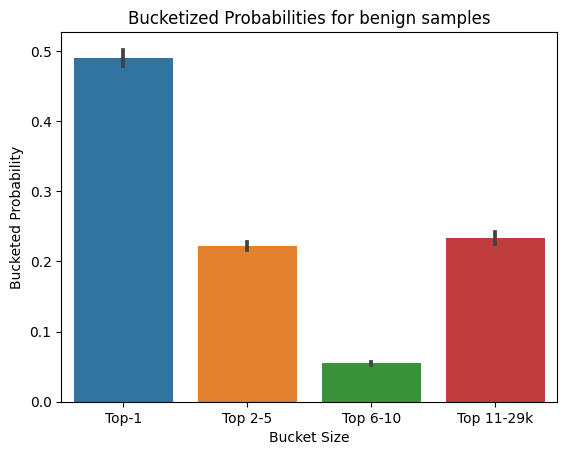

In [20]:
df_buckets_baseline = pd.DataFrame(buckets_baseline).T
df_buckets_baseline.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']

g = sns.barplot(data=df_buckets_baseline)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities for benign samples")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Baseline_GPT_Optim.jpg", dpi=500)


In [21]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_adv_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_first_success_probs]
buckets_adv = [[], [], [], []] 
for dist in all_adv_probs_sorted_desc:
    buckets_adv[0].append(dist[0].to("cpu").item())
    buckets_adv[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_adv[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_adv[3].append(torch.sum(dist[11:]).to("cpu").item())

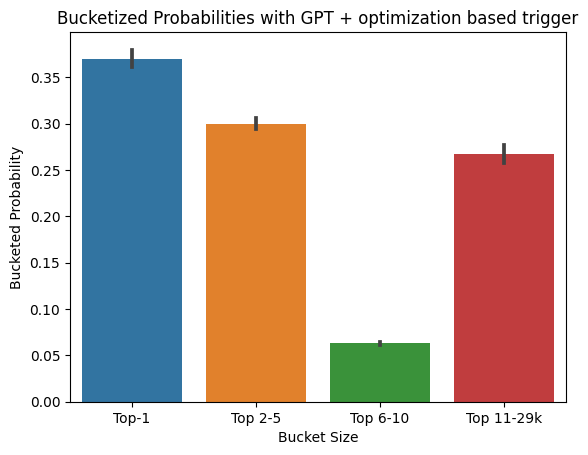

In [22]:
df_buckets_adv = pd.DataFrame(buckets_adv).T
df_buckets_adv.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']

g = sns.barplot(data=df_buckets_adv)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities with GPT + optimization based trigger")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Adv_GPT_Optim.jpg", dpi=500)


In [23]:
base_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in base_rank_prob_tracker]
base_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in base_rank_prob_tracker]

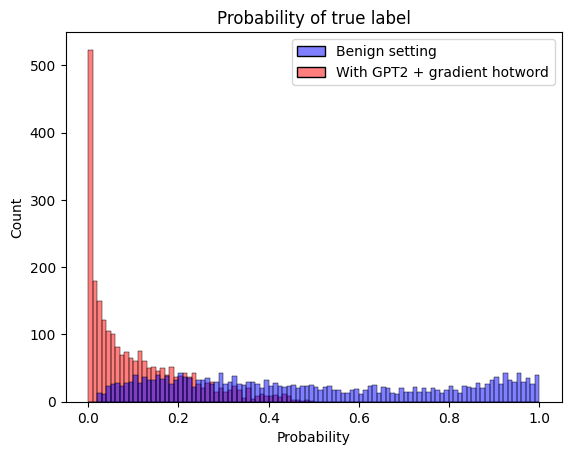

In [24]:
df_true_labels = pd.DataFrame([base_rank_prob_tracker_og, base_rank_prob_tracker_post]).T
df_true_labels.columns = ["Benign setting", "With GPT2 + gradient hotword"]


g = sns.histplot(data=df_true_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability of true label")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_base_gpt_optim.jpg", dpi=500)




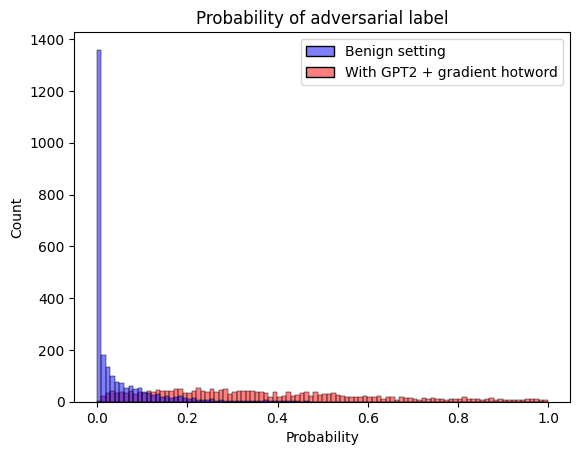

In [25]:
adv_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in adv_rank_prob_tracker]
adv_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in adv_rank_prob_tracker]

df_adv_labels = pd.DataFrame([adv_rank_prob_tracker_og, adv_rank_prob_tracker_post]).T
df_adv_labels.columns = ["Benign setting", "With GPT2 + gradient hotword"]

g = sns.histplot(data=df_adv_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability of adversarial label")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_base_gpt_optim.jpg", dpi=500)


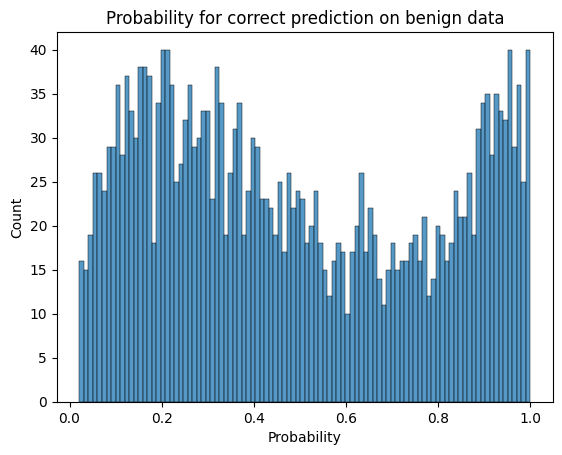

In [26]:
g = sns.histplot(data=base_rank_prob_tracker_og, bins=100)
plt.xlabel("Probability")
plt.title("Probability for correct prediction on benign data")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_baseline.jpg", dpi=500)



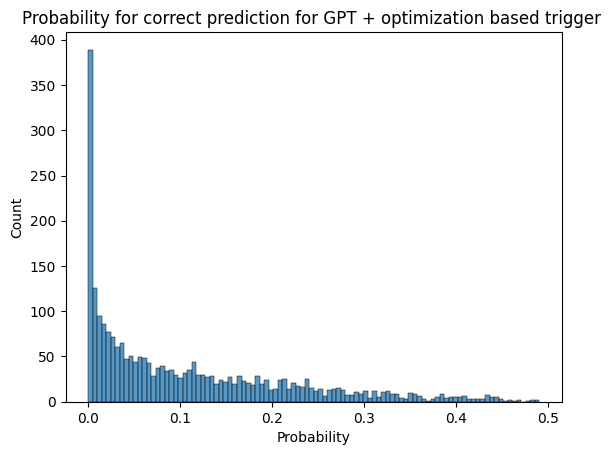

In [27]:
g = sns.histplot(data=base_rank_prob_tracker_post, bins=100)
plt.xlabel("Probability")
plt.title("Probability for correct prediction for GPT + optimization based trigger ")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_with_GPT_optim.jpg", dpi=500)



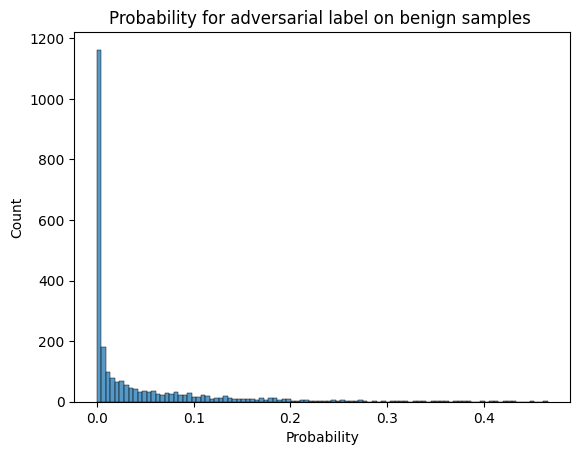

In [28]:
g = sns.histplot(data=adv_rank_prob_tracker_og, bins=100)
plt.xlabel("Probability")
plt.title("Probability for adversarial label on benign samples ")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_GPT_Optim.jpg", dpi=500)



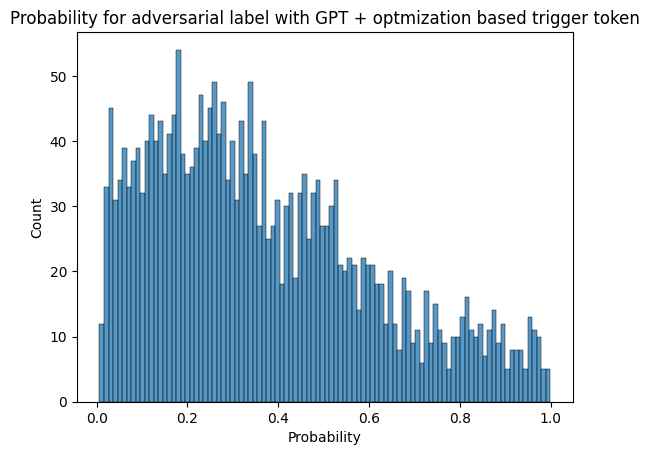

In [29]:
g = sns.histplot(data=adv_rank_prob_tracker_post, bins=100)
plt.xlabel("Probability")
plt.title("Probability for adversarial label with GPT + optmization based trigger token")
fig = g.get_figure()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_with_gpt_optim_only.jpg", dpi=500)



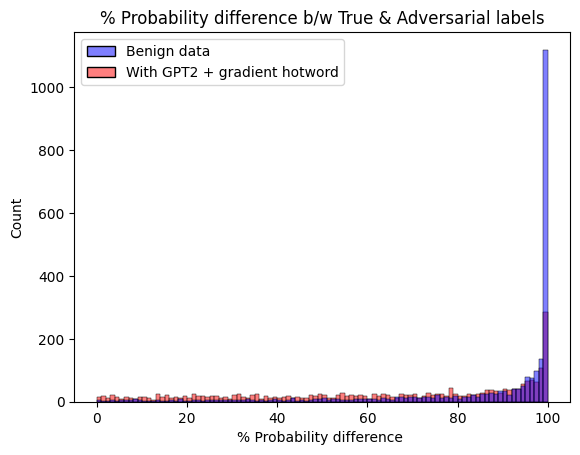

In [30]:

# Compute and plot differences
delta_base_adv_benign = ((np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) / np.asarray(base_rank_prob_tracker_og))*100
delta_base_adv_adv =  ((np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post)) / np.asarray(adv_rank_prob_tracker_post))*100

df_delta_base_adv_benign = pd.DataFrame([delta_base_adv_benign, delta_base_adv_adv]).T
df_delta_base_adv_benign.columns = ['Benign data', 'With GPT2 + gradient hotword']

g = sns.histplot(data=df_delta_base_adv_benign, bins=100, palette=['blue', 'red'])
plt.xlabel("% Probability difference ")
plt.title("% Probability difference b/w True & Adversarial labels")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_delta_gpt_optim.jpg", dpi=500)





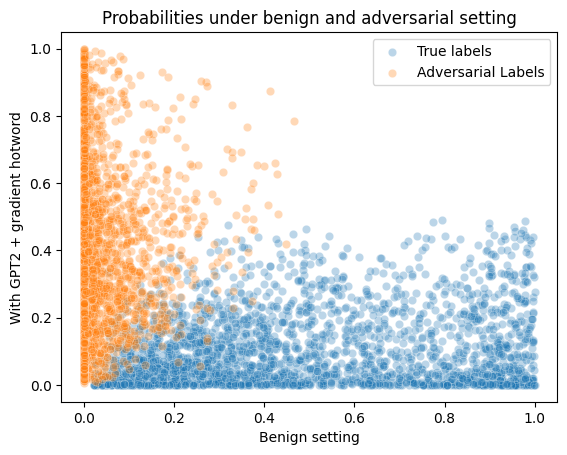

In [31]:
g = sns.scatterplot(data=df_true_labels, x=df_true_labels.columns[0], y=df_true_labels.columns[1], alpha=0.3)
g = sns.scatterplot(data=df_adv_labels, x=df_adv_labels.columns[0], y=df_adv_labels.columns[1], alpha=0.3)
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["True labels","Adversarial Labels"])
fig = g.get_figure()
plt.show()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_gpt_optim.jpg", dpi=500)

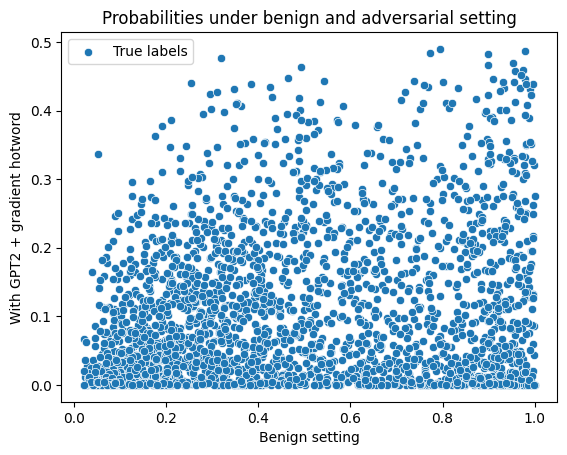

In [32]:
g = sns.scatterplot(data=df_true_labels, x=df_true_labels.columns[0], y=df_true_labels.columns[1])
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["True labels"])
fig = g.get_figure()
plt.show()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_gpt_optim_true.jpg", dpi=500)

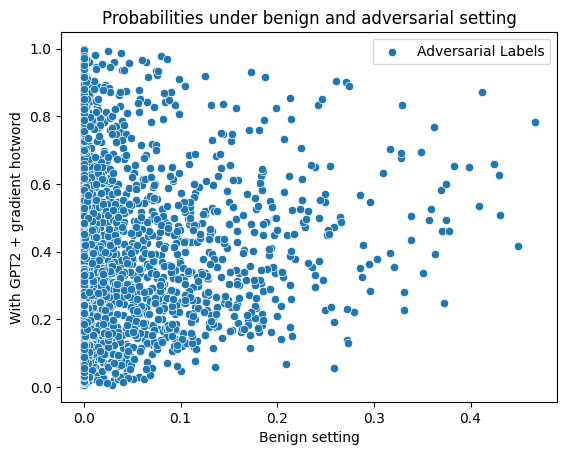

In [33]:
g = sns.scatterplot(data=df_adv_labels, x=df_adv_labels.columns[0], y=df_adv_labels.columns[1])
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["Adversarial Labels"])
fig = g.get_figure()
plt.show()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_gpt_optim_adv.jpg", dpi=500)

In [34]:
# Compute and plot differences
delta_benign = (np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) 
delta_adv =  (np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post))

In [35]:
df_delta = pd.DataFrame([delta_benign, delta_adv]).T
df_delta.columns = ['Benign setting', 'With GPT + gradient hotword']

In [36]:
# Compute and plot differences
delta_benign_percent = ((np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) / np.asarray(base_rank_prob_tracker_og))*100
delta_adv_percent =  ((np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post)) / np.asarray(adv_rank_prob_tracker_post))*100

In [37]:
df_delta_percent = pd.DataFrame([delta_benign_percent, delta_adv_percent]).T
df_delta_percent.columns = ['Benign setting', 'With GPT + gradient hotword']

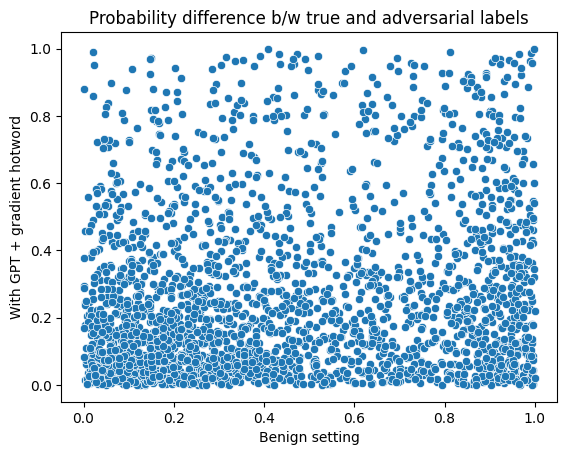

In [38]:
g = sns.scatterplot(data=df_delta, x=df_delta.columns[0], y=df_delta.columns[1])
fig = g.get_figure()
plt.title("Probability difference b/w true and adversarial labels")
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_delta_gpt_optim.jpg", dpi=500)

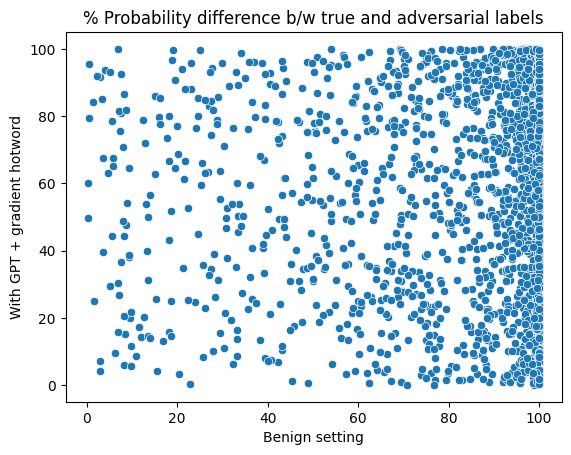

In [39]:
g = sns.scatterplot(data=df_delta_percent, x=df_delta.columns[0], y=df_delta.columns[1])
fig = g.get_figure()
plt.title("% Probability difference b/w true and adversarial labels")
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_delta_percent_gpt_optim.jpg", dpi=500)

In [40]:

mean_base_og = np.mean(base_rank_prob_tracker_og)
std_base_og = np.std(base_rank_prob_tracker_og)

mean_base_post = np.mean(base_rank_prob_tracker_post)
std_base_post = np.std(base_rank_prob_tracker_post)

print("Mean base OG : ", mean_base_og, "Std base OG : ", std_base_og)
print("Mean base Post : ", mean_base_post, "Std base Post : ", std_base_post)


mean_adv_og = np.mean(adv_rank_prob_tracker_og)
std_adv_og = np.std(adv_rank_prob_tracker_og)

mean_adv_post = np.mean(adv_rank_prob_tracker_post)
std_adv_post = np.std(adv_rank_prob_tracker_post)

print("Mean adv OG : ", mean_adv_og, "Std adv OG : ", std_adv_og)
print("Mean adv Post : ", mean_adv_post, "Std adv Post : ", std_adv_post)

mean_delta_benign = np.mean(delta_benign)
std_delta_benign = np.std(delta_benign)

mean_delta_benign_percent = np.std(delta_benign_percent)
std_delta_benign_percent = np.std(delta_benign_percent)

print("Mean diff b/w true adv labels in benign setting is : ", mean_delta_benign, " and dev is ", std_delta_benign)
print("Mean % diff b/w true adv labels in benign setting is : ", mean_delta_benign_percent, " and dev is ", std_delta_benign_percent)


mean_delta_adv = np.mean(delta_adv)
std_delta_adv = np.std(delta_adv)

mean_delta_adv_percent = np.std(delta_adv_percent)
std_delta_adv_percent = np.std(delta_adv_percent)

print("Mean diff b/w true adv labels in benign setting is : ", mean_delta_adv, " and dev is ", std_delta_adv)
print("Mean % diff b/w true adv labels in benign setting is : ", mean_delta_adv_percent, " and dev is ", std_delta_adv_percent)





Mean base OG :  0.4894681399975667 Std base OG :  0.2973696213155292
Mean base Post :  0.10638992144393715 Std base Post :  0.11037216920600812
Mean adv OG :  0.0399620629937644 Std adv OG :  0.06861026901672748
Mean adv Post :  0.369741172305654 Std adv Post :  0.2439330005469687
Mean diff b/w true adv labels in benign setting is :  0.4495060770038024  and dev is  0.31523345623863097
Mean % diff b/w true adv labels in benign setting is :  22.791178690209474  and dev is  22.791178690209474
Mean diff b/w true adv labels in benign setting is :  0.26335125086171685  and dev is  0.25014829855641785
Mean % diff b/w true adv labels in benign setting is :  30.86487860370348  and dev is  30.86487860370348


# GPT Triggers only

In [4]:
numpy_file = "/home/zsarwar/NLP/autoprompt/autoprompt/Results/Arrays/bert_large_cased_2500_bert-large-cased_gpt_true_adv_token_false_remove_periods_true_add_comma_false_attempts_20_probs.npy"
loaded_dict = np.load(numpy_file, allow_pickle=True)
loaded_dict = loaded_dict.item()


In [5]:
all_first_success_probs = []
all_baseline_probs = []
all_true_labels = []
all_adv_labels = []
inc=0
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        true_label = loaded_dict['results_adversarial']['all_labels_triggers'][i][0]
        adv_label = loaded_dict['results_adversarial']['all_pred_labels_triggers'][i][first_succ_rank][0]
        adv_probs = loaded_dict['results_adversarial']['all_probs_triggers'][i][first_succ_rank.item()]
        base_probs = loaded_dict["results_baseline_real"]['all_probs_base'][i]
        all_first_success_probs.append(adv_probs)
        all_baseline_probs.append(base_probs)
        all_true_labels.append(true_label)
        all_adv_labels.append(adv_label)
    else:
        inc+=1
        

all_first_success_probs = [F.softmax(probs, dim=-1) for probs in all_first_success_probs]
all_baseline_probs = [F.softmax(probs, dim=-1) for probs in all_baseline_probs]

In [6]:
# Sorting predictions of base and adv (tokens and their predictions)
top_k = len(all_baseline_probs[0])

base_top_k = []
adv_top_k = []

probs, indices = torch.topk(all_baseline_probs[0], k=top_k, largest=True)
base_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_baseline_probs]
adv_top_k = [torch.topk(probs, k=top_k, largest=True) for probs in all_first_success_probs]

In [7]:
# Track ranking of baseline top_1 before and after adversarial triggers
base_rank_prob_tracker = []
for i, label in enumerate(all_true_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    base_rank_prob_tracker.append(prob_rank_track)


In [8]:
# Track ranking of adv top_1 before and after adversarial triggers
adv_rank_prob_tracker = []
for i, label in enumerate(all_adv_labels):
    idx_true_base = torch.where(base_top_k[i][1] == label)[0]
    prob_true_base = base_top_k[i][0][idx_true_base]

    idx_true_adv = torch.where(adv_top_k[i][1] == label)[0]
    prob_true_adv = adv_top_k[i][0][idx_true_adv]

    prob_rank_track = [(idx_true_base, prob_true_base), (idx_true_adv, prob_true_adv)]
    adv_rank_prob_tracker.append(prob_rank_track)


In [9]:
  # Compute entropy of top_10 predictions
# Saving Top-k predictions of base and adv (tokens and their predictions)
top_10 = 10

base_top_10 = []
adv_top_10 = []

base_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_baseline_probs]
base_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in base_top_10]
base_top_10 = [probs.detach().cpu().numpy() for probs in base_top_10]
base_entropies = [entropy(b_10, base=2) for b_10 in base_top_10]
base_entropies_median = np.median(base_entropies)
base_entropies_mean = np.mean(base_entropies)
base_entropies_dev = np.std(base_entropies)


adv_top_10 = [torch.topk(probs, k=top_10, largest=True) for probs in all_first_success_probs]
adv_top_10 = [(prob[0] / torch.sum(prob[0], dim=-1)) for prob in adv_top_10]
adv_top_10 = [probs.detach().cpu().numpy() for probs in adv_top_10]
adv_entropies = [entropy(a_10, base=2) for a_10 in adv_top_10]
adv_entropies_median = np.median(adv_entropies)
adv_entropies_mean = np.mean(adv_entropies)
adv_entropies_dev = np.std(adv_entropies)

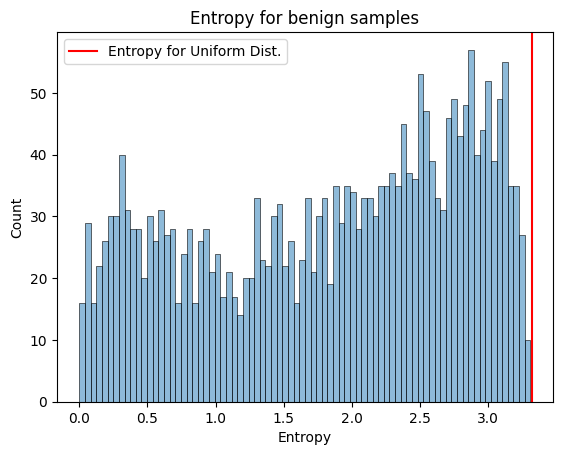

In [10]:
df_base_entropies = pd.DataFrame(base_entropies)
#df_base_entropies.columns = ['Entropy']

g = sns.histplot(data=df_base_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy for benign samples")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Baseline.jpg", dpi=500)




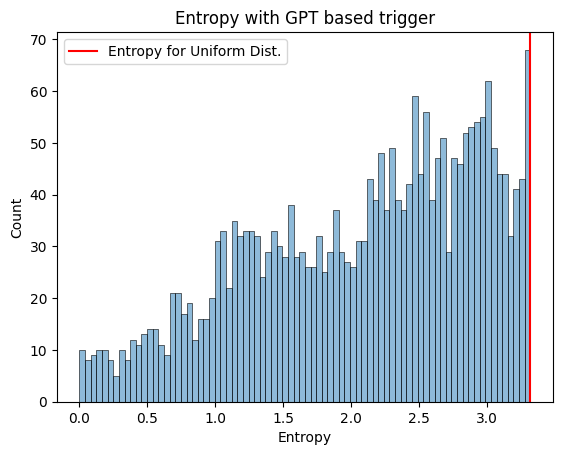

In [11]:
df_adv_entropies = pd.DataFrame(adv_entropies)
g = sns.histplot(data=df_adv_entropies, bins=80)
g.axvline(3.321, 0,2, color='red', label="Upper Bound on Entropy")
plt.xlabel("Entropy")
plt.legend(labels=["Entropy for Uniform Dist."])
plt.title("Entropy with GPT based trigger")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Entropy_Adv_GPT.jpg", dpi=500)




In [12]:
# Plotting losses ~ CE loss tells us how confident the model was for the correct prediction 
# Can do it for True and adversarial labels in both (baseline and adversarial examples) to get an understanding of the loss surface.


all_first_success_losses = []
all_baseline_losses = []
# Subsample adversarial instances and their first success indices as well as their original counterparts
for i in range(len(loaded_dict['results_adversarial']['all_first_success_ranks'])):
    first_succ_rank = loaded_dict['results_adversarial']['all_first_success_ranks'][i]
    if (first_succ_rank != -100):
        adv_loss = loaded_dict['results_adversarial']['all_losses_triggers'][i][first_succ_rank.item()]
        # Replace "results_baseline" with "results_baseline_real" 
        base_loss = loaded_dict['results_baseline_real']['all_losses_base'][i]
        all_first_success_losses.append(adv_loss.to("cpu").item())
        all_baseline_losses.append(base_loss.to("cpu").item())
        


In [13]:
# Compute and store the loss on the adversarial tokens when they were predicted as the correct labels 
all_losses_adversarial_tokens = []
for i in range(len(all_adv_labels)):
    adv_prob = all_first_success_probs[i][all_adv_labels[i]]
    loss_on_adv = torch.log(adv_prob)
    all_losses_adversarial_tokens.append(loss_on_adv.to("cpu").item())


In [14]:
# Compute and store the delta between Top-1 and Top-2 prediction for baseline tokens
 

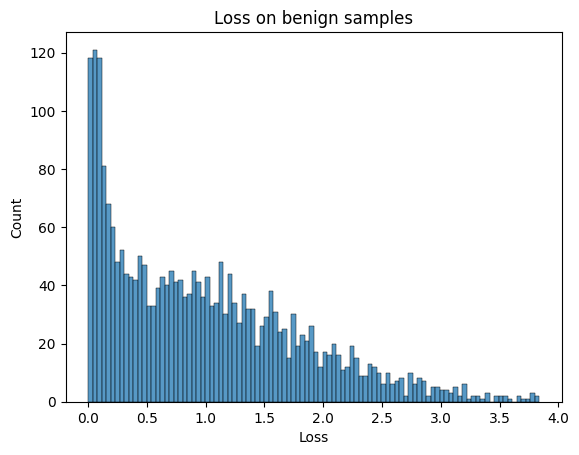

In [15]:
all_baseline_losses = [-loss for loss in all_baseline_losses]
g = sns.histplot(data=all_baseline_losses, bins=100)
plt.xlabel("Loss")
plt.title("Loss on benign samples")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Baseline.jpg", dpi=500)



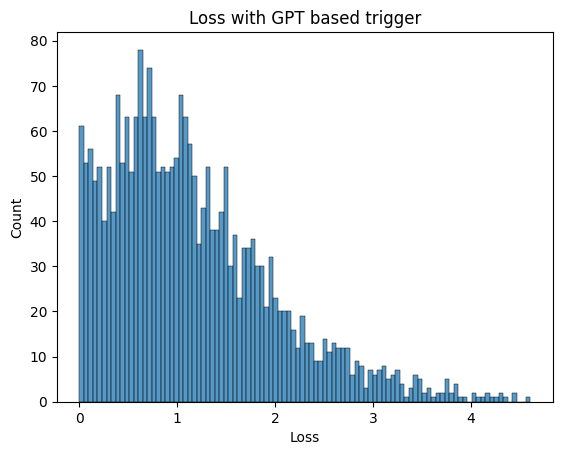

In [16]:
all_first_success_losses = [-loss for loss in all_first_success_losses]
all_losses_adversarial_tokens = [-loss for loss in all_losses_adversarial_tokens]
g = sns.histplot(data=all_losses_adversarial_tokens, bins=100)
plt.xlabel("Loss")
plt.title("Loss with GPT based trigger")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Loss_Adversarial_GPT.jpg", dpi=500)



In [17]:
# Bucket probs into Top-1, Top 2-5, 5-10, 10-Infinity

In [18]:
# Sort the vectors and add up the bin probs over the entire dataset

# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_baseline_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_baseline_probs]
buckets_baseline = [[], [], [], []] 
for dist in all_baseline_probs_sorted_desc:
    buckets_baseline[0].append(dist[0].to("cpu").item())
    buckets_baseline[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_baseline[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_baseline[3].append(torch.sum(dist[11:]).to("cpu").item())

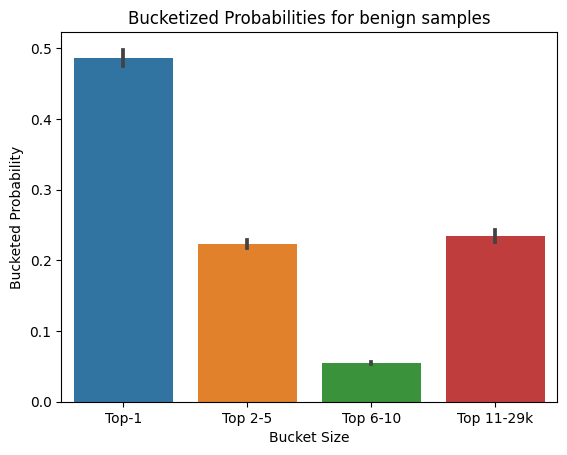

In [19]:
df_buckets_baseline = pd.DataFrame(buckets_baseline).T
df_buckets_baseline.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']

g = sns.barplot(data=df_buckets_baseline)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities for benign samples")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Baseline.jpg", dpi=500)


In [20]:
# Sort the vectors and add up the bin probs over the entire dataset
# Storing probs into Top-1, Top-2-5, Top5-10, Top 10-Infinity
all_adv_probs_sorted_desc = [torch.sort(prob, descending=True).values for prob in all_first_success_probs]
buckets_adv = [[], [], [], []] 
for dist in all_adv_probs_sorted_desc:
    buckets_adv[0].append(dist[0].to("cpu").item())
    buckets_adv[1].append(torch.sum(dist[1:6]).to("cpu").item())
    buckets_adv[2].append(torch.sum(dist[6:11]).to("cpu").item())
    buckets_adv[3].append(torch.sum(dist[11:]).to("cpu").item())

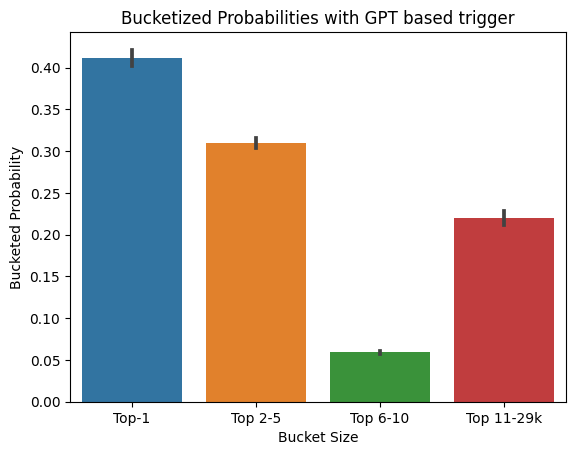

In [21]:
df_buckets_adv = pd.DataFrame(buckets_adv).T
df_buckets_adv.columns = ['Top-1', 'Top 2-5', 'Top 6-10', 'Top 11-29k']

g = sns.barplot(data=df_buckets_adv)
plt.xlabel("Bucket Size")
plt.ylabel("Bucketed Probability")
plt.title("Bucketized Probabilities with GPT based trigger")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/Bucket_Barplot_Adv_GPT.jpg", dpi=500)


In [22]:
base_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in base_rank_prob_tracker]
base_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in base_rank_prob_tracker]

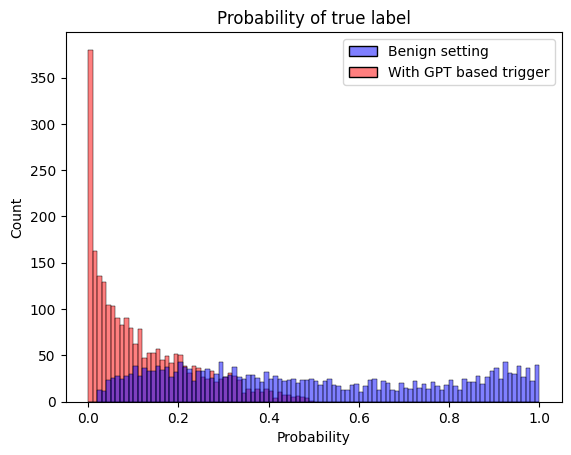

In [23]:
df_true_labels = pd.DataFrame([base_rank_prob_tracker_og, base_rank_prob_tracker_post]).T
df_true_labels.columns = ["Benign setting", "With GPT based trigger"]
g = sns.histplot(data=df_true_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability of true label")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_base_gpt.jpg", dpi=500)




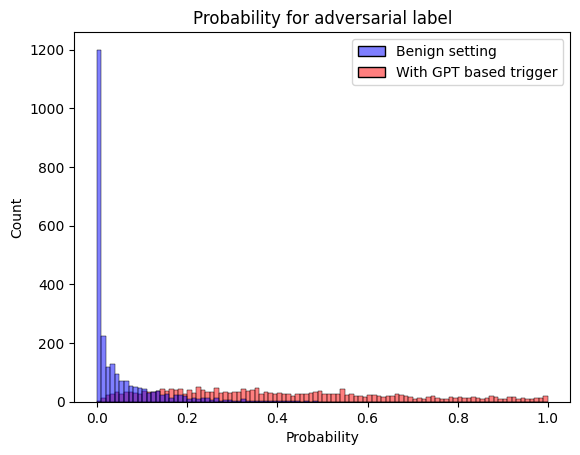

In [24]:

adv_rank_prob_tracker_og = [prob[0][1].to("cpu").item() for prob in adv_rank_prob_tracker]
adv_rank_prob_tracker_post = [prob[1][1].to("cpu").item() for prob in adv_rank_prob_tracker]

df_adv_labels = pd.DataFrame([adv_rank_prob_tracker_og, adv_rank_prob_tracker_post]).T
df_adv_labels.columns = ["Benign setting", "With GPT based trigger"]

g = sns.histplot(data=df_adv_labels, bins=100, palette=['blue', 'red'])
plt.xlabel("Probability")
plt.title("Probability for adversarial label")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_base_gpt.jpg", dpi=500)


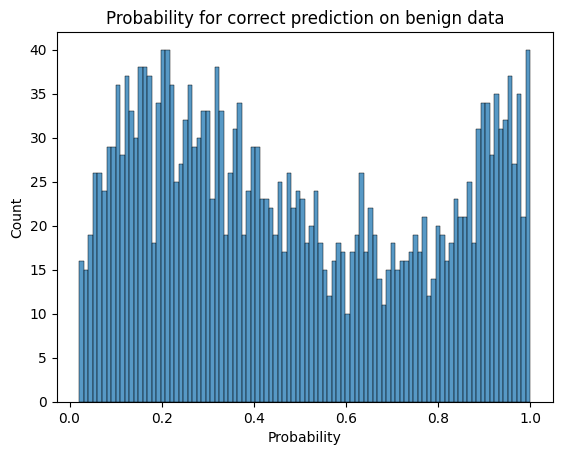

In [25]:
g = sns.histplot(data=base_rank_prob_tracker_og, bins=100)
plt.xlabel("Probability")
plt.title("Probability for correct prediction on benign data")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_baseline.jpg", dpi=500)



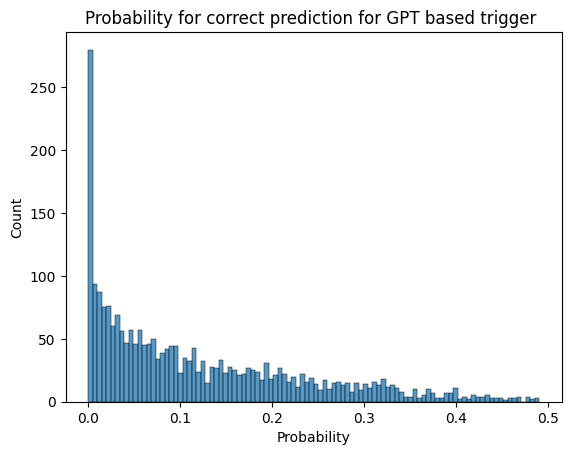

In [26]:
g = sns.histplot(data=base_rank_prob_tracker_post, bins=100)
plt.xlabel("Probability")
plt.title("Probability for correct prediction for GPT based trigger ")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_true_label_with_GPT.jpg", dpi=500)



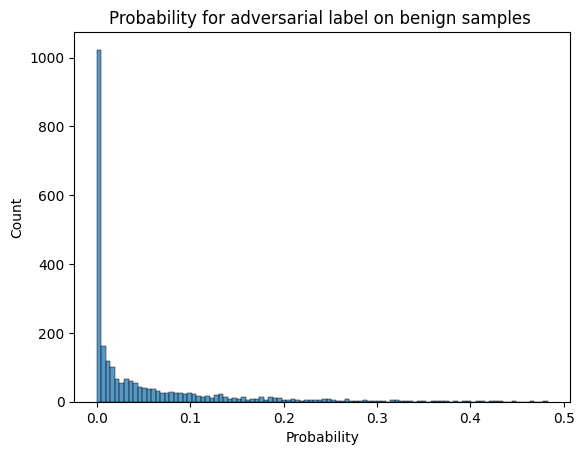

In [27]:
g = sns.histplot(data=adv_rank_prob_tracker_og, bins=100)
plt.xlabel("Probability")
plt.title("Probability for adversarial label on benign samples ")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_GPT.jpg", dpi=500)



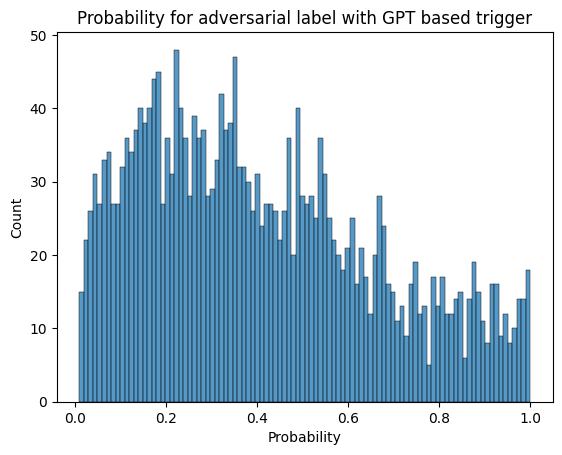

In [28]:
g = sns.histplot(data=adv_rank_prob_tracker_post, bins=100)
plt.xlabel("Probability")
plt.title("Probability for adversarial label with GPT based trigger")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_adv_label_with_gpt.jpg", dpi=500)



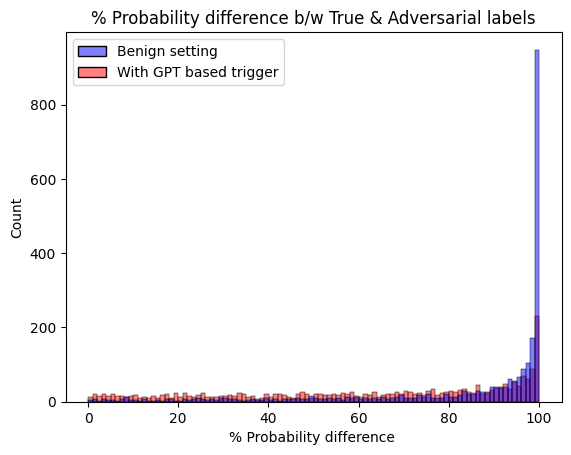

In [29]:

# Compute and plot differences
delta_base_adv_benign = ((np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) / np.asarray(base_rank_prob_tracker_og))*100
delta_base_adv_adv =  ((np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post)) / np.asarray(adv_rank_prob_tracker_post))*100

df_delta_base_adv_benign = pd.DataFrame([delta_base_adv_benign, delta_base_adv_adv]).T
df_delta_base_adv_benign.columns = ['Benign setting', 'With GPT based trigger']

g = sns.histplot(data=df_delta_base_adv_benign, bins=100, palette=['blue', 'red'])
plt.xlabel("% Probability difference ")
plt.title("% Probability difference b/w True & Adversarial labels")
fig = g.get_figure()
#fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_delta_gpt.jpg", dpi=500)





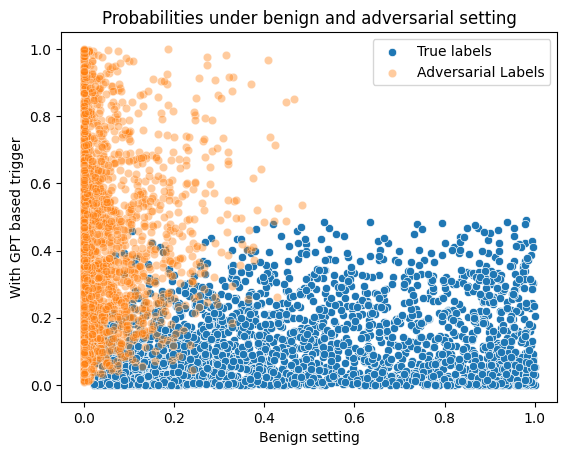

In [30]:
g = sns.scatterplot(data=df_true_labels, x=df_true_labels.columns[0], y=df_true_labels.columns[1])
g = sns.scatterplot(data=df_adv_labels, x=df_adv_labels.columns[0], y=df_adv_labels.columns[1], alpha=0.4)
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["True labels","Adversarial Labels"])
fig = g.get_figure()
plt.show()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_gpt.jpg", dpi=500)

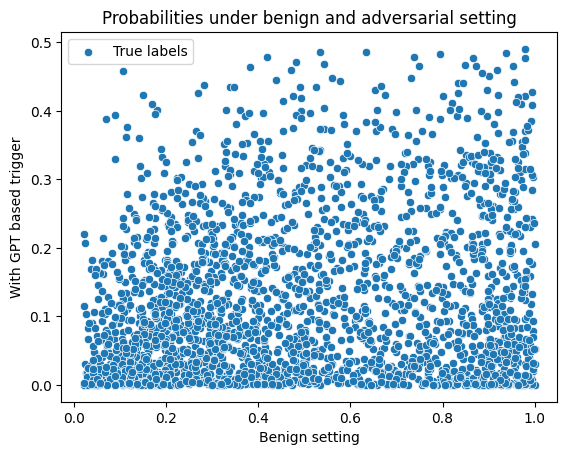

In [31]:
g = sns.scatterplot(data=df_true_labels, x=df_true_labels.columns[0], y=df_true_labels.columns[1])
#g = sns.scatterplot(data=df_adv_labels, x=df_adv_labels.columns[0], y=df_adv_labels.columns[1], alpha=0.4)
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["True labels","Adversarial Labels"])
fig = g.get_figure()
plt.show()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_gpt_true.jpg", dpi=500)

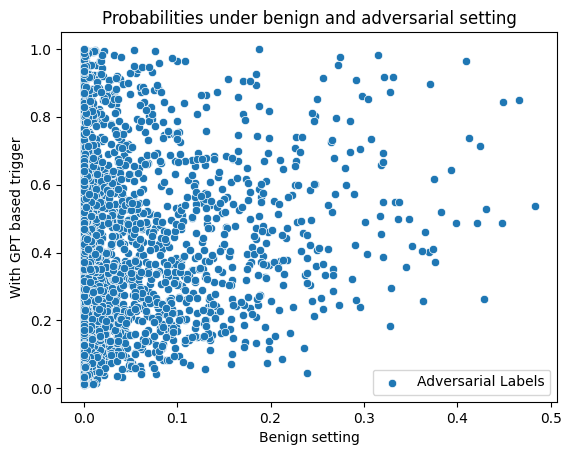

In [32]:

g = sns.scatterplot(data=df_adv_labels, x=df_adv_labels.columns[0], y=df_adv_labels.columns[1])
plt.title("Probabilities under benign and adversarial setting")
plt.legend(labels=["Adversarial Labels"])
fig = g.get_figure()
plt.show()
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_gpt_adv.jpg", dpi=500)

In [33]:
# Compute and plot differences
delta_benign = (np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) 
delta_adv =  (np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post))

In [34]:
df_delta = pd.DataFrame([delta_benign, delta_adv]).T
df_delta.columns = ['Benign setting', 'With GPT2 based trigger']

In [35]:
# Compute and plot differences
delta_benign_percent = ((np.asarray(base_rank_prob_tracker_og) - np.asarray(adv_rank_prob_tracker_og)) / np.asarray(base_rank_prob_tracker_og))*100
delta_adv_percent =  ((np.asarray(adv_rank_prob_tracker_post) - np.asarray(base_rank_prob_tracker_post)) / np.asarray(adv_rank_prob_tracker_post))*100

In [36]:
df_delta_percent = pd.DataFrame([delta_benign_percent, delta_adv_percent]).T
df_delta_percent.columns = ['Benign setting', 'With GPT2 based trigger']

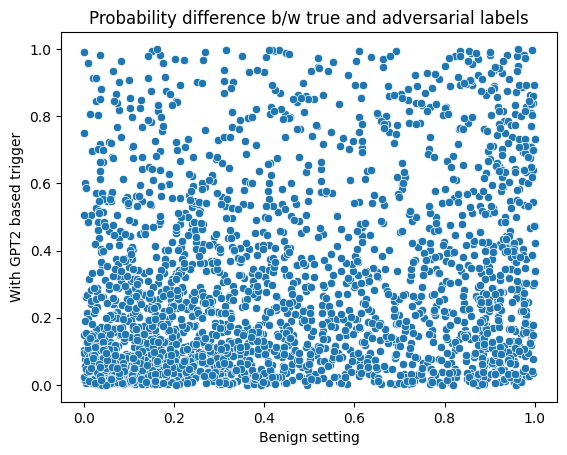

In [37]:
g = sns.scatterplot(data=df_delta, x=df_delta.columns[0], y=df_delta.columns[1])
fig = g.get_figure()
plt.title("Probability difference b/w true and adversarial labels")
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_delta_gpt.jpg", dpi=500)

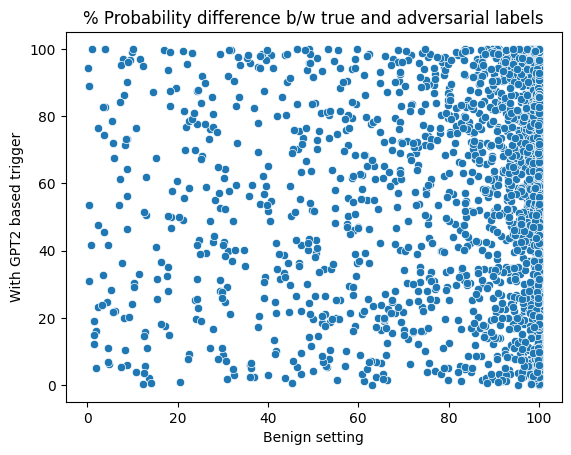

In [38]:
g = sns.scatterplot(data=df_delta_percent, x=df_delta.columns[0], y=df_delta.columns[1])
fig = g.get_figure()
plt.title("% Probability difference b/w true and adversarial labels")
fig.savefig("/home/zsarwar/NLP/autoprompt/autoprompt/Results/Plots/prob_scatter_delta_percent_gpt.jpg", dpi=500)

In [39]:

mean_base_og = np.mean(base_rank_prob_tracker_og)
std_base_og = np.std(base_rank_prob_tracker_og)

mean_base_post = np.mean(base_rank_prob_tracker_post)
std_base_post = np.std(base_rank_prob_tracker_post)

print("Mean base OG : ", mean_base_og, "Std base OG : ", std_base_og)
print("Mean base Post : ", mean_base_post, "Std base Post : ", std_base_post)


mean_adv_og = np.mean(adv_rank_prob_tracker_og)
std_adv_og = np.std(adv_rank_prob_tracker_og)

mean_adv_post = np.mean(adv_rank_prob_tracker_post)
std_adv_post = np.std(adv_rank_prob_tracker_post)

print("Mean adv OG : ", mean_adv_og, "Std adv OG : ", std_adv_og)
print("Mean adv Post : ", mean_adv_post, "Std adv Post : ", std_adv_post)

mean_delta_benign = np.mean(delta_benign)
std_delta_benign = np.std(delta_benign)

mean_delta_benign_percent = np.std(delta_benign_percent)
std_delta_benign_percent = np.std(delta_benign_percent)

print("Mean diff b/w true adv labels in benign setting is : ", mean_delta_benign, " and dev is ", std_delta_benign)
print("Mean % diff b/w true adv labels in benign setting is : ", mean_delta_benign_percent, " and dev is ", std_delta_benign_percent)


mean_delta_adv = np.mean(delta_adv)
std_delta_adv = np.std(delta_adv)

mean_delta_adv_percent = np.std(delta_adv_percent)
std_delta_adv_percent = np.std(delta_adv_percent)

print("Mean diff b/w true adv labels in benign setting is : ", mean_delta_adv, " and dev is ", std_delta_adv)
print("Mean % diff b/w true adv labels in benign setting is : ", mean_delta_adv_percent, " and dev is ", std_delta_adv_percent)





Mean base OG :  0.48658103012622833 Std base OG :  0.2962100267936545
Mean base Post :  0.11997750659230517 Std base Post :  0.11415428517900421
Mean adv OG :  0.04670238076561246 Std adv OG :  0.0747937573714592
Mean adv Post :  0.41125543062574405 Std adv Post :  0.2577022836618926
Mean diff b/w true adv labels in benign setting is :  0.4398786493606158  and dev is  0.31546037527045345
Mean % diff b/w true adv labels in benign setting is :  24.4245316735924  and dev is  24.4245316735924
Mean diff b/w true adv labels in benign setting is :  0.2912779240334389  and dev is  0.2703725382466995
Mean % diff b/w true adv labels in benign setting is :  30.830643641893623  and dev is  30.830643641893623
